## ДЗ к Уроку 4. Кейс 1. Построение и оценка модели

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.
2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты моделирования ARIMA (смотрим на порядок моделей и порядок сезонности и формируем признаки соответствующего вида (порядой интегрирования d=1 - нужна первая разность, p = 10 - берем глубину истории 10)).
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты моделирования ARIMA (смотрим на порядок моделей и порядок сезонности).
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки bp 4-х точек.
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)
6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

## ДЗ к Уроку 5. Кейс 1. Аномалии и артефакты

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю
3. сделайте ее перрасчет (ресемплинг) в представление по неделям.
4. Постройте модель предсказания 1-й точки от текущей (h=1, p, q и d - необходимо выбрать с учетом задачи).
5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

%matplotlib inline
import warnings 

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


### Загрузка данных

#### цена нефти:

In [2]:
brent_data = pd.read_csv('my_BRENT2019.csv', index_col=[0])
brent_data.sort_index(inplace=True)
brent_data.index = pd.to_datetime(brent_data.index)
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [3]:
brent_data.index

DatetimeIndex(['2010-09-01', '2010-09-02', '2010-09-03', '2010-09-04',
               '2010-09-05', '2010-09-06', '2010-09-07', '2010-09-08',
               '2010-09-09', '2010-09-10',
               ...
               '2019-08-21', '2019-08-22', '2019-08-23', '2019-08-25',
               '2019-08-26', '2019-08-27', '2019-08-28', '2019-08-29',
               '2019-08-30', '2019-09-01'],
              dtype='datetime64[ns]', name='Дата', length=2667, freq=None)

### кросс-курс валют (рубль-доллар, рубль-евро)

In [4]:
rub_doll = pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx', index_col=[1])
rub_doll.drop(columns=['nominal', 'cdx'], inplace=True)
rub_doll.rename(columns={'curs':'curs dollar'},inplace=True)
rub_doll.index = pd.to_datetime(rub_doll.index)
rub_doll.head()

,curs dollar
data,
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [5]:
rub_euro = pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx', index_col=[1])
rub_euro.drop(columns=['nominal', 'cdx'], inplace=True)
rub_euro.rename(columns={'curs':'curs euro'},inplace=True)
rub_euro.index = pd.to_datetime(rub_euro.index)
rub_euro.head()

,curs euro
data,
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


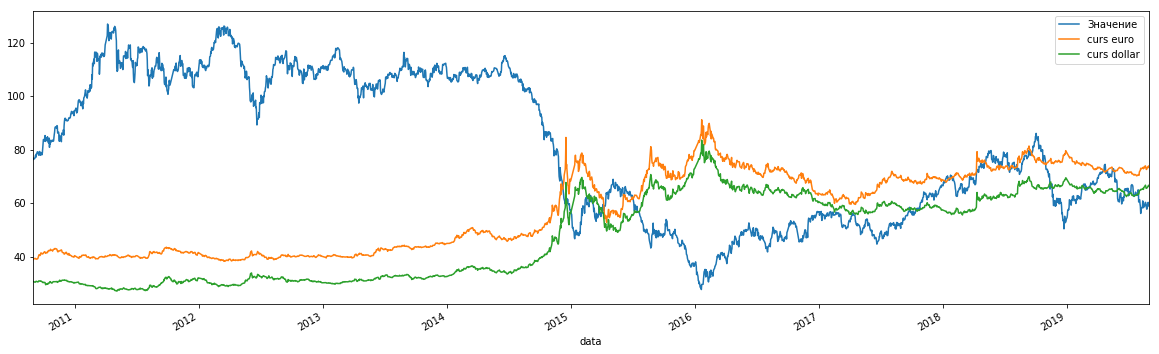

In [6]:
plt.figure(figsize=(20, 6))
brent_data['Значение'].plot()
rub_euro['curs euro'].plot()
rub_doll['curs dollar'].plot()
plt.legend()
plt.show()

Объединим данные по дате

In [7]:
brent_data = pd.concat([brent_data, rub_doll, rub_euro], axis=1)

In [8]:
np.sum(brent_data.isna())

Значение           470
year               470
month              470
dayofmonth         470
quarter            470
dayofyear          470
weekofyear         470
dayofweek          470
is_holiday         470
is_prev_holiday    470
is_next_holiday    470
curs dollar        909
curs euro          909
dtype: int64

Есть пропуски (дни без торговли). Посмотрим на них

In [9]:
ind_brent = np.where(brent_data['Значение'].isna() == True)[0]
brent_data.iloc[ind_brent[:5],:]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,curs dollar,curs euro
2010-09-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0826,40.8115
2010-09-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.9480,41.2599
2010-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.5094,41.6606
2010-10-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9086,41.6717
2010-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.1243,42.3939


Не торгуем раз в неделю (воскресенье)

In [10]:
ind_doll = np.where(brent_data['curs dollar'].isna() == True)[0]
brent_data.iloc[ind_doll[:5],:]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,curs dollar,curs euro
2010-09-05,76.63,2010.0,9.0,5.0,3.0,248.0,35.0,6.0,0.0,1.0,0.0,NaN,NaN
2010-09-06,76.87,2010.0,9.0,6.0,3.0,249.0,36.0,0.0,1.0,0.0,0.0,NaN,NaN
2010-09-13,79.19,2010.0,9.0,13.0,3.0,256.0,37.0,0.0,0.0,0.0,0.0,NaN,NaN
2010-09-19,78.23,2010.0,9.0,19.0,3.0,262.0,37.0,6.0,0.0,0.0,0.0,NaN,NaN
2010-09-20,79.36,2010.0,9.0,20.0,3.0,263.0,38.0,0.0,0.0,0.0,0.0,NaN,NaN


In [11]:
ind_euro = np.where(brent_data['curs euro'].isna() == True)[0]
brent_data.iloc[ind_euro[:5],:]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,curs dollar,curs euro
2010-09-05,76.63,2010.0,9.0,5.0,3.0,248.0,35.0,6.0,0.0,1.0,0.0,NaN,NaN
2010-09-06,76.87,2010.0,9.0,6.0,3.0,249.0,36.0,0.0,1.0,0.0,0.0,NaN,NaN
2010-09-13,79.19,2010.0,9.0,13.0,3.0,256.0,37.0,0.0,0.0,0.0,0.0,NaN,NaN
2010-09-19,78.23,2010.0,9.0,19.0,3.0,262.0,37.0,6.0,0.0,0.0,0.0,NaN,NaN
2010-09-20,79.36,2010.0,9.0,20.0,3.0,263.0,38.0,0.0,0.0,0.0,0.0,NaN,NaN


с пропусками для валют - похоже на отсутствие торговли воскресенье-понедельник (пока не закончен день - нет ккросс-курса)

### Будем заполнять последним известным значением все пропуски

In [12]:
brent_data['curs dollar'].fillna(method='ffill', inplace=True)
brent_data['curs euro'].fillna(method='ffill', inplace=True)
brent_data['Значение'].fillna(method='ffill', inplace=True)

Поля календаря слабо влияют на значения этого ряда - исключаем их

In [13]:
brent_data = brent_data[['Значение','curs dollar','curs euro']]
#brent_data.index = pd.to_datetime(brent_data.index).date
brent_data.head()

,Значение,curs dollar,curs euro
2010-09-01,76.37,30.8669,39.0127
2010-09-02,76.89,30.8001,39.1654
2010-09-03,76.57,30.6858,39.2901
2010-09-04,76.62,30.6922,39.3505
2010-09-05,76.63,30.6922,39.3505


Сделаем ресемплинг на неделю

In [14]:
brent_data_w= brent_data.resample('W').mean()
brent_data_w.head()

,Значение,curs dollar,curs euro
2010-09-05,76.616000,30.747440,39.233840
2010-09-12,77.673333,30.777050,39.302883
2010-09-19,78.590000,30.887129,39.984557
2010-09-26,78.558571,31.003800,41.040657
2010-10-03,81.582857,30.585086,41.382686


In [15]:
brent_data_w.dropna(inplace=True)
brent_data_w.head()

,Значение,curs dollar,curs euro
2010-09-05,76.616000,30.747440,39.233840
2010-09-12,77.673333,30.777050,39.302883
2010-09-19,78.590000,30.887129,39.984557
2010-09-26,78.558571,31.003800,41.040657
2010-10-03,81.582857,30.585086,41.382686


## Задание урока 4

Сделаем прогноз на 1 день вперед h=1

In [16]:
adfuller(brent_data_w['Значение'], regression='ctt')

(-2.789814681988333,
 0.40389846475802266,
 5,
 464,
 {'1%': -4.396274283817996,
  '5%': -3.8451769989336255,
  '10%': -3.561172289966388},
 1974.0745861660207)

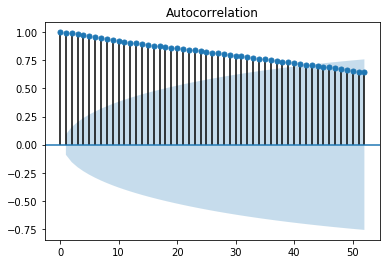

C:\Users\1\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


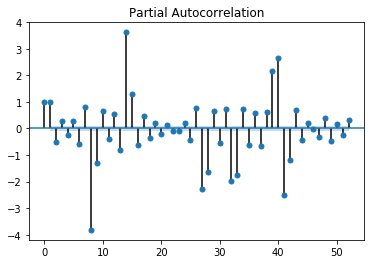

In [17]:
plot_acf(brent_data_w['Значение'], lags=52)
plt.show()

plot_pacf(brent_data_w['Значение'], lags=52)
plt.show()

Ряд нестационарный зависит от длинной истории (45 недель назад влияют на прогноз)

делаем 1-е разности (продифференцируем ряд)

In [18]:
brent_data_w['d_brent'] = brent_data_w['Значение'].diff(1)
brent_data_w['doll_brent'] = brent_data_w['curs dollar'].diff(1)
brent_data_w['euro_brent'] = brent_data_w['curs euro'].diff(1)
brent_data_w.dropna(inplace=True)  

Проверим разности на стационарность

In [19]:
adfuller(brent_data_w['d_brent'], regression='ctt')

(-13.687495282869374,
 2.532471418393612e-22,
 1,
 467,
 {'1%': -4.396111652921828,
  '5%': -3.84509447012365,
  '10%': -3.5611212965378463},
 1975.1079117943239)

P-value = 0 - ряд стационарен - Таким образом, порядок интегрирования 1

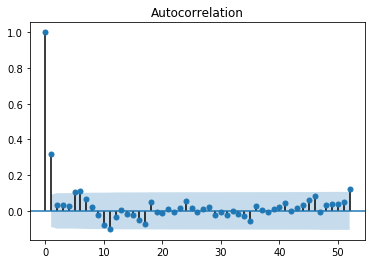

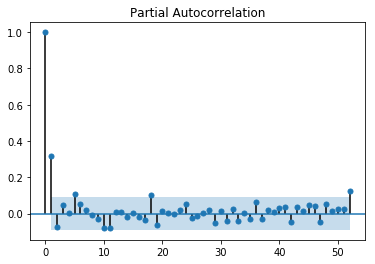

In [20]:
plot_acf(brent_data_w['d_brent'], lags=52)
plt.show()

plot_pacf(brent_data_w['d_brent'], lags=52)
plt.show()

Влияет только первое значение по глубине истории для разностей

### ARIMA

параметры

In [21]:
S = 0
d, D = 1, 0
p, P = 6, 0
q, Q = 6, 0

ps, Ps = np.arange(0, p + 1), np.arange(0, P + 1)
qs, Qs = np.arange(0, q + 1), np.arange(0, Q + 1)

In [22]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

49

#### Перебор параметров:

In [23]:
%%time
results = []
opt_aic = float('inf')
warnings.filterwarnings('ignore')

for n, param in enumerate(parameters_list):
    try:
        model=SARIMAX(brent_data_w['Значение'].values[330:427], order=(param[0], d, param[1]), 
                      seasonal_order=(param[2], D, param[3], S), 
                                enforce_stationarity= False ,
                                enforce_invertibility=False).fit(disp=-1)
    except:
        continue
    aic = model.aic
    if aic < opt_aic:
        opt_model = model
        opt_aic = aic
        opt_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 12.8 s


Топ-5 моделей

In [24]:
result_table = pd.DataFrame(results, columns=['parameters', 'aic'])
result_table.sort_values(by='aic', ascending=True).head()

,parameters,aic
6,"(0, 6, 0, 0)",353.156235
19,"(2, 5, 0, 0)",354.934158
5,"(0, 5, 0, 0)",355.112982
13,"(1, 6, 0, 0)",355.125658
20,"(2, 6, 0, 0)",355.903118


#### Лучшая модель:

In [25]:
print(opt_model.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   97
Model:               SARIMAX(0, 1, 6)   Log Likelihood                -169.578
Date:                Wed, 18 Dec 2019   AIC                            353.156
Time:                        23:24:57   BIC                            370.577
Sample:                             0   HQIC                           360.178
                                 - 97                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3764      0.122      3.085      0.002       0.137       0.616
ma.L2          0.0136      0.126      0.108      0.914      -0.233       0.260
ma.L3         -0.0786      0.114     -0.688      0.4

#### Анализ остатков:

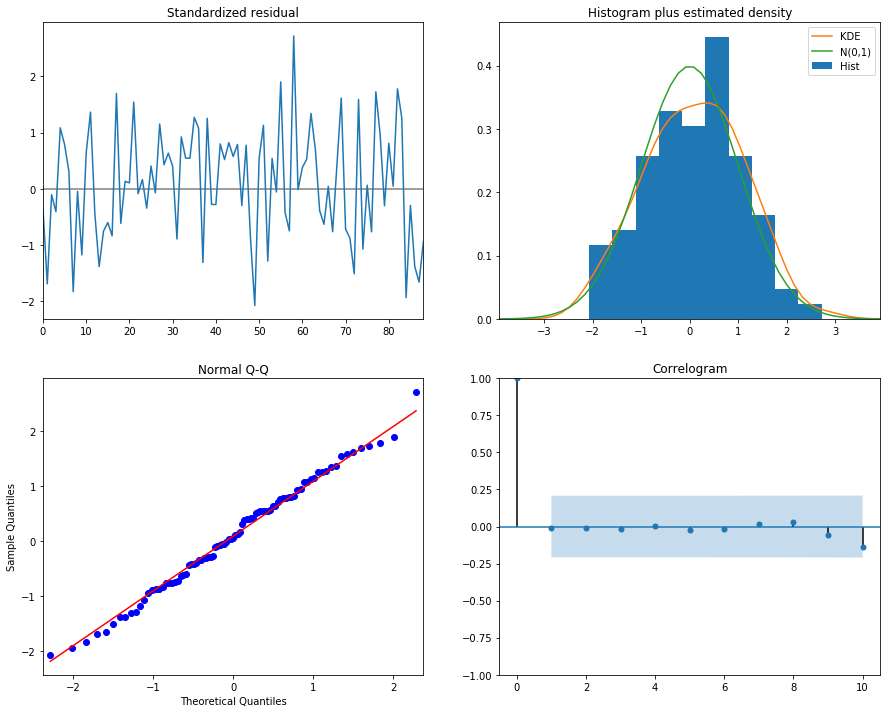

In [26]:
opt_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Распределение остатков близко к нормальному. Остатки стационарны.


## Выводы по ARIMA

Таким образом, рабочая модель : 
   - q = 6 -  сглаживание
   - d = 1 - учитываем 1-е разности 
   - p = 0 - все значения для текущего момента 

   - сезона нет.


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
C:\Users\1\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: DeprecationWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  stop = base_index._start + (key + 1) * base_index._step
C:\Users\

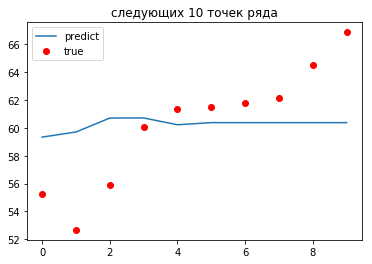

In [67]:
final_model=SARIMAX(brent_data_w['Значение'].values[350:427], order=(0, 1, 6), 
                      seasonal_order=(0,0, 0, 0) ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False ).fit(disp=-1)
pred_dynamic = final_model.forecast(10)    #делаем предсказание на 10 точки от текущего
 
plt.plot(pred_dynamic, label='predict' )
#Отобразим истинный значения 
plt.plot(brent_data_w['Значение'].values[427:437],'or',label='true')
plt.title('следующих 10 точек ряда')
plt.legend()
plt.plot()
plt.show()

In [68]:
q=6
p=1 # добавляю историю, только для генерации наиболее общего способа построения признаков для примеров

h = 1 # горизонт прогноза



### Создание признаков

Берем сглаживание 
Текущее значение
текущее значение 1-й разности

In [29]:
brent_data_w['ma1']=brent_data_w['Значение'].rolling(q).mean()
brent_data_w = brent_data_w.iloc[1:,:]
brent_data_w.head()

,Значение,curs dollar,curs euro,d_brent,doll_brent,euro_brent,ma1
2010-09-19,78.590000,30.887129,39.984557,0.916667,0.110079,0.681674,NaN
2010-09-26,78.558571,31.003800,41.040657,-0.031429,0.116671,1.056100,NaN
2010-10-03,81.582857,30.585086,41.382686,3.024286,-0.418714,0.342029,NaN
2010-10-10,84.152857,30.112129,41.636057,2.570000,-0.472957,0.253371,NaN
2010-10-17,83.392857,30.017657,41.987514,-0.760000,-0.094471,0.351457,80.658413


In [30]:
for i in range(p):
    brent_data_w[f'p{i+1}'] = 0
    brent_data_w[f'p{i+1}'].values[p:]=brent_data_w['Значение'].values[p-i-1:-i-1]
    

brent_data_w.head()

,Значение,curs dollar,curs euro,d_brent,doll_brent,euro_brent,ma1,p1
2010-09-19,78.590000,30.887129,39.984557,0.916667,0.110079,0.681674,NaN,0
2010-09-26,78.558571,31.003800,41.040657,-0.031429,0.116671,1.056100,NaN,78
2010-10-03,81.582857,30.585086,41.382686,3.024286,-0.418714,0.342029,NaN,78
2010-10-10,84.152857,30.112129,41.636057,2.570000,-0.472957,0.253371,NaN,81
2010-10-17,83.392857,30.017657,41.987514,-0.760000,-0.094471,0.351457,80.658413,84


Будем  смотреть только на текущие значения (без глубины истории), 1-е разности и сглаживание по MA

Построим целевой признак и признаки для обучения:

In [33]:
brent_data_w.dropna(inplace=True)  
df = brent_data_w.iloc[p:-h,:].copy()  # входы модели 
df['target'] = 0
df['target']=brent_data_w.iloc[p+h:,0].values.copy()   # выход модели
brent_data_w.dropna(inplace=True)    
df.head()

,Значение,curs dollar,curs euro,d_brent,doll_brent,euro_brent,ma1,p1,target
2010-10-24,82.810000,30.512871,42.491329,-0.582857,0.495214,0.503814,81.514524,83,83.330000
2010-10-31,83.330000,30.562071,42.509329,0.520000,0.049200,0.018000,82.304524,82,87.003333
2010-11-07,87.003333,30.777117,43.020217,3.673333,0.215045,0.510888,83.711984,83,87.552857
2010-11-14,87.552857,30.750257,42.485571,0.549524,-0.026860,-0.534645,84.706984,87,84.677143
2010-11-21,84.677143,31.029600,42.289557,-2.875714,0.279343,-0.196014,84.794365,87,85.177143


### Разделение данных на train и test

In [34]:
def split_data_b(df, split_date):
    return df.loc[df.index.get_level_values(df.index.name) <= split_date].copy(), \
           df.loc[df.index.get_level_values(df.index.name) >  split_date].copy()

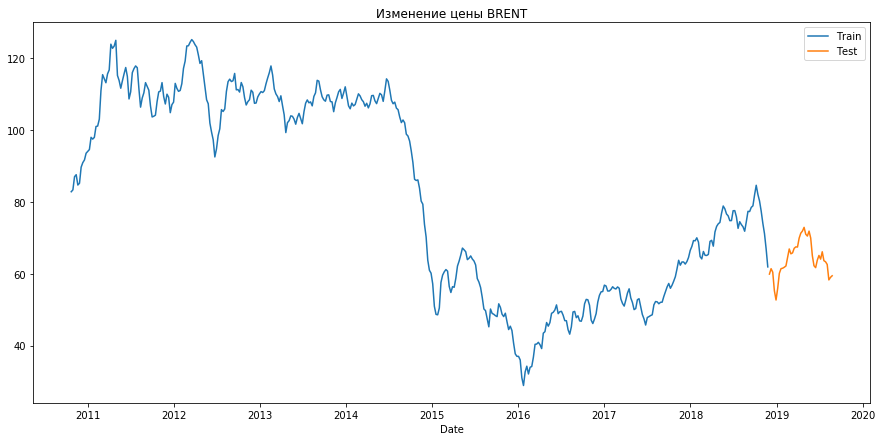

In [35]:
train, test = split_data_b(df, '2018-12-01')

plt.figure( figsize=(15, 7))
plt.plot(train.index,train.iloc[:,0], label='Train' )
plt.plot(test.index,test.iloc[:,0], label='Test')
plt.xlabel('Date')
plt.title('Изменение цены BRENT')
plt.legend(loc='best')
plt.show()

In [36]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]
X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]

In [37]:
X_train.shape

(423, 8)

### Обучение модели

In [38]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

C:\Users\1\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\1\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\1\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [39]:
model_g = GradientBoostingRegressor(max_depth=4, random_state=0, n_estimators=1250)

In [40]:
scx= StandardScaler().fit(X_train)
X_train_s = scx.transform(X_train)
X_test_s = scx.transform(X_test)

scy= StandardScaler().fit(y_train.values.reshape(y_train.shape[0], 1))
y_train_s = scy.transform(y_train.values.reshape(y_train.shape[0], 1))
y_test_s = scy.transform(y_test.values.reshape(y_test.shape[0], 1))

C:\Users\1\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
model_g.fit(X_train_s, y_train_s)

C:\Users\1\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1250, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

### Прямое прогнозирование

#### Наиболее важные признаки:

In [42]:
feature_importances = pd.Series(model_g.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False)

Значение       0.529198
curs euro      0.327546
curs dollar    0.136195
ma1            0.003730
d_brent        0.001572
euro_brent     0.000685
doll_brent     0.000673
p1             0.000401
dtype: float64

Самая сильная связь -текущее значение цены нефти и курс доллара :)

Следующий по силе признак - сглаживание цены

Исторические значения цены и разности значительно слабее при решении задачи предсказания как по курсам, так и по самой цене нефти 


## Прогноз

In [43]:
y_test_pred_s = model_g.predict(X_test_s)

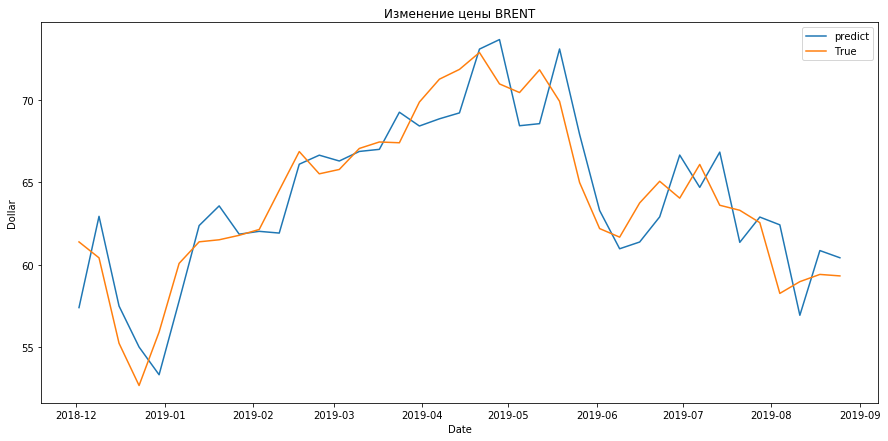

In [44]:
plt.figure( figsize=(15, 7))
plt.plot(test.index,scy.inverse_transform(y_test_pred_s), label='predict' )
plt.plot(test.index,scy.inverse_transform(y_test_s), label='True')
plt.xlabel('Date')
plt.title('Изменение цены BRENT')
plt.ylabel('Dollar')
plt.legend()
plt.show()

Ошибка

In [45]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [46]:
er_g = mean_absolute_percentage_error(y_true=scy.inverse_transform( y_test_s),y_pred = scy.inverse_transform( y_test_pred_s))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   8.64000555810406 %


Исключим курсы валют из прогноза, т.к. они коррелированы с текущим значением цены.

In [47]:
list_feat =(np.array(range(p+2))+6)

df_rec=df.iloc[:,[0,3]+list_feat.tolist()].copy()
df_rec.head()

,Значение,d_brent,ma1,p1,target
2010-10-24,82.810000,-0.582857,81.514524,83,83.330000
2010-10-31,83.330000,0.520000,82.304524,82,87.003333
2010-11-07,87.003333,3.673333,83.711984,83,87.552857
2010-11-14,87.552857,0.549524,84.706984,87,84.677143
2010-11-21,84.677143,-2.875714,84.794365,87,85.177143


C:\Users\1\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':
C:\Users\1\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


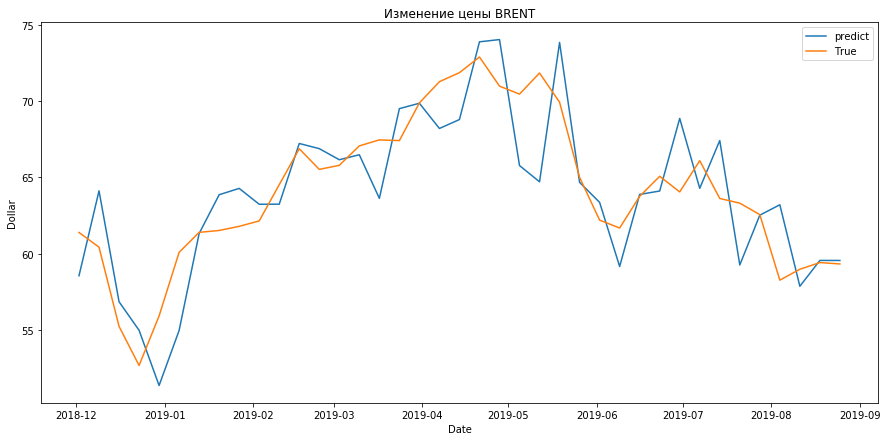

ошибка градиентного бустинга MAPE :   8.835880322446263 %


In [48]:
train_c, test_c = split_data_b(df_rec, '2018-12-01')

X_train_c = train_c.iloc[:, :-1]
y_train_c = train_c.iloc[:, -1]
X_test_c = test_c.iloc[:, :-1]
y_test_c = test_c.iloc[:, -1]

model_gc = GradientBoostingRegressor(max_depth=10, random_state=0, n_estimators=1550)

scxc= StandardScaler().fit(X_train_c)
X_train_cs = scxc.transform(X_train_c)
X_test_cs = scxc.transform(X_test_c)

scyc= StandardScaler().fit(y_train_c.values.reshape(y_train_c.shape[0], 1))
y_train_cs = scyc.transform(y_train_c.values.reshape(y_train_c.shape[0], 1))
y_test_cs = scyc.transform(y_test_c.values.reshape(y_test_c.shape[0], 1))

model_gc.fit(X_train_cs, y_train_cs)


y_test_pred_cs = model_gc.predict(X_test_cs)


plt.figure( figsize=(15, 7))
plt.plot(test_c.index,scyc.inverse_transform(y_test_pred_cs), label='predict' )
plt.plot(test_c.index,scyc.inverse_transform(y_test_cs), label='True')
plt.xlabel('Date')
plt.title('Изменение цены BRENT')
plt.ylabel('Dollar')
plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=scyc.inverse_transform( y_test_cs),y_pred = scyc.inverse_transform( y_test_pred_cs))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')


Ошибка модели несколько больше, но нет внешних факторов (курсов валют). Можем построить рекурсивную модель 

### Рекурсивное прогнозирование


In [49]:
x_shape = X_train_c.shape[0]

In [50]:
df_rec.head() 

,Значение,d_brent,ma1,p1,target
2010-10-24,82.810000,-0.582857,81.514524,83,83.330000
2010-10-31,83.330000,0.520000,82.304524,82,87.003333
2010-11-07,87.003333,3.673333,83.711984,83,87.552857
2010-11-14,87.552857,0.549524,84.706984,87,84.677143
2010-11-21,84.677143,-2.875714,84.794365,87,85.177143


In [51]:
print(X_test_c.iloc[0,:])

Значение    59.882857
d_brent     -2.002857
ma1         68.550000
p1          61.000000
Name: 2018-12-02 00:00:00, dtype: float64


#### Начало исходной тестовой части данных для рекурсивной модели:

In [53]:
ind_test=np.where(df_rec.index.get_level_values(df_rec.index.name) == '2019-01-06')[0][0]
df_rec_test = df_rec.iloc[ind_test-q+1:,:].copy()
df_rec_test.head(5+q)

,Значение,d_brent,ma1,p1,target
2018-12-02,59.882857,-2.002857,68.550000,61,61.390000
2018-12-09,61.390000,1.507143,65.877381,59,60.422857
2018-12-16,60.422857,-0.967143,63.606905,61,55.232857
2018-12-23,55.232857,-5.190000,60.953095,60,52.668571
2018-12-30,52.668571,-2.564286,58.580476,55,55.916000
2019-01-06,55.916000,3.247429,57.585524,52,60.085714
2019-01-13,60.085714,4.169714,57.619333,55,61.395714
2019-01-20,61.395714,1.310000,57.620286,60,61.520000
2019-01-27,61.520000,0.124286,57.803143,61,61.791429
2019-02-03,61.791429,0.271429,58.896238,61,62.145714


#### Рекурсии (обновление ):

In [54]:
h_step = 20  # число шагов модели в рекурсивной форме

for i in range(h_step):
    f_w = scxc.transform(df_rec_test.iloc[i+q, :-1].values.reshape(1, 4))
    df_rec_test.iloc[i+q+1, 0] = scyc.inverse_transform(model_gc.predict(f_w))[0]
    df_rec_test.iloc[i+q+1, 1] = df_rec_test.iloc[i+q+1, 0] - df_rec_test.iloc[i+q, 0] 
    df_rec_test.iloc[i+q+1, 2] = np.mean(df_rec_test.iloc[i+1:i+q+1, 0] )
    df_rec_test.iloc[i+q+1, 2] = df_rec_test.iloc[i+q, 0] 


In [55]:

df_rec_test.head(5+q)

,Значение,d_brent,ma1,p1,target
2018-12-02,59.882857,-2.002857,68.550000,61,61.390000
2018-12-09,61.390000,1.507143,65.877381,59,60.422857
2018-12-16,60.422857,-0.967143,63.606905,61,55.232857
2018-12-23,55.232857,-5.190000,60.953095,60,52.668571
2018-12-30,52.668571,-2.564286,58.580476,55,55.916000
2019-01-06,55.916000,3.247429,57.585524,52,60.085714
2019-01-13,60.085714,4.169714,57.619333,55,61.395714
2019-01-20,61.319258,1.233544,60.085714,60,61.520000
2019-01-27,63.247790,1.928531,61.319258,61,61.791429
2019-02-03,63.251929,0.004139,63.247790,61,62.145714


In [56]:
scyc.inverse_transform(y_test_pred_cs[:20])

array([58.55108237, 64.11896273, 56.84755802, 54.97678729, 51.35438097,
       54.96405501, 61.31925849, 63.86396011, 64.27898282, 63.23831398,
       63.24417797, 67.22329596, 66.88614051, 66.15829214, 66.48398317,
       63.62667106, 69.50925309, 69.8613717 , 68.20831176, 68.79386209])

#### h_step тестовых отсчетов:

- прямое прогнозирование (GB);
- рекурсивное прогнозирование (GB with recursion).

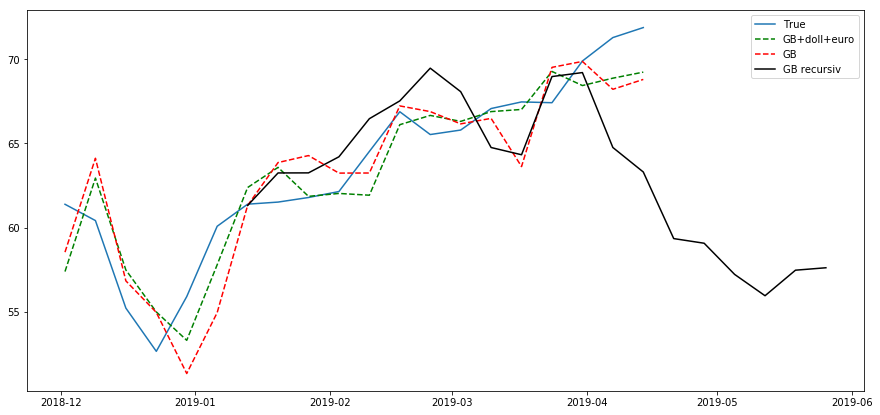

In [60]:
plt.figure(figsize=(15, 7))

plt.plot(y_test.index[:h_step],y_test.values[:h_step], label='True')
plt.plot(y_test.index[:h_step],scy.inverse_transform(y_test_pred_s[:h_step]),'--g',label='GB+doll+euro')
plt.plot(y_test.index[:h_step],scyc.inverse_transform(y_test_pred_cs[:h_step]), '--r',label='GB')
plt.plot(df_rec_test.index[q:h_step+q],df_rec_test.iloc[1+q:h_step+q+1, 0].values, 'k',label='GB recursiv')


plt.legend()
plt.show()

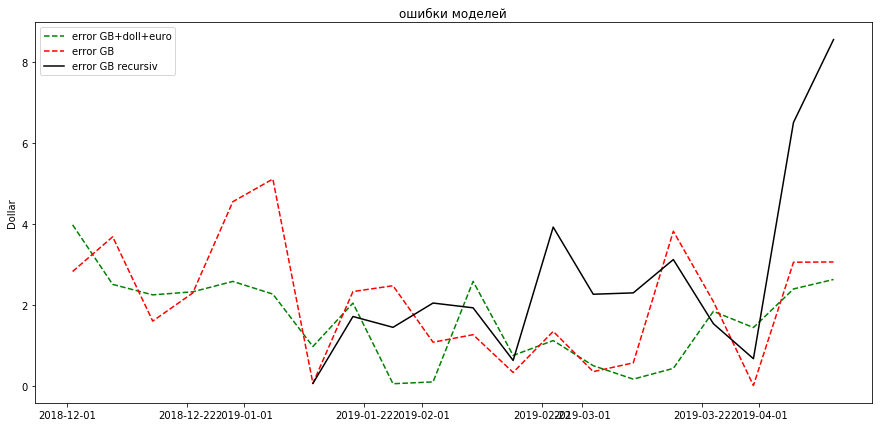

In [66]:
plt.figure(figsize=(15, 7))

plt.plot(y_test.index[:h_step],np.abs(scy.inverse_transform(y_test_pred_s[:h_step])-y_test.values[:h_step]),'--g',label='error GB+doll+euro')
plt.plot(y_test.index[:h_step],np.abs(scyc.inverse_transform(y_test_pred_cs[:h_step])-y_test.values[:h_step]), '--r',label='error GB')
plt.plot(df_rec_test.index[q:h_step],np.abs(df_rec_test.iloc[1+q:h_step+1, 0].values - y_test.values[q:h_step]), 'k',label='error GB recursiv')
plt.title('ошибки моделей')
plt.ylabel('Dollar')
plt.legend()
plt.show()

**Вывод:**  

Курс валюты связан с ценой нефти, но скорее зависит от нее.Поэтому ряд с учетом курса и без него работает практически одинаково.

Рекурсивный прогноз слабее, но тенденцию ряда видимт дальше, чем на p - истории (в нашем случае пока есть монотонность). Рекурсивный прогноз хорошо работает в рядах с выраженными временными связями (например "Потребление энергии")

Посмотрим на другой горизонт прогноза h = 10

## Изменим h (h=10)

C:\Users\1\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()
C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
C:\Users\1\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


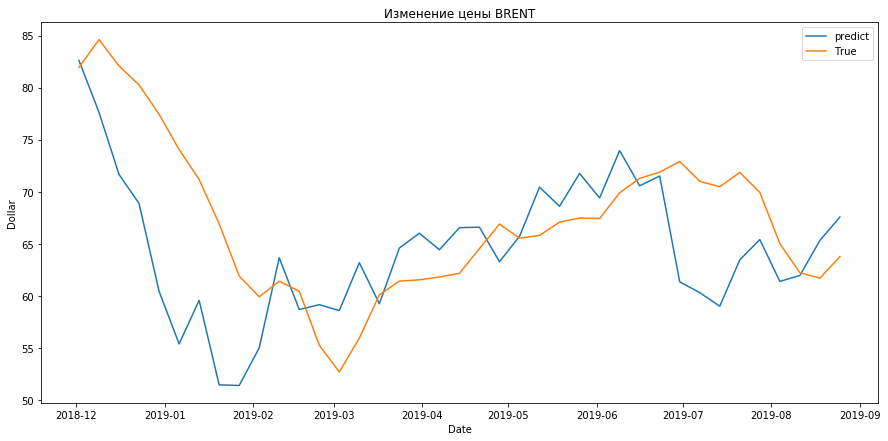

ошибка градиентного бустинга MAPE :   11.699017953372048 %


In [75]:
h_10=10
    
df_rec10 = df_rec.copy()
df_rec10['target'].values[h_10:]=df_rec10['target'].values[:-h_10]

train_c10, test_c10 = split_data_b(df_rec10, '2018-12-01')

X_train_c10 = train_c10.iloc[:, :-1]
y_train_c10 = train_c10.iloc[:, -1]
X_test_c10 = test_c10.iloc[:, :-1]
y_test_c10 = test_c10.iloc[:, -1]

model_gc10 = GradientBoostingRegressor(max_depth=4, random_state=0, n_estimators=1050)

scxc10= StandardScaler().fit(X_train_c10)
X_train_cs10 = scxc10.transform(X_train_c10)
X_test_cs10 = scxc10.transform(X_test_c10)

scyc10= StandardScaler().fit(y_train_c10.values.reshape(y_train_c10.shape[0], 1))
y_train_cs10 = scyc10.transform(y_train_c10.values.reshape(y_train_c10.shape[0], 1))
y_test_cs10 = scyc10.transform(y_test_c10.values.reshape(y_test_c10.shape[0], 1))

model_gc10.fit(X_train_cs10, y_train_cs10)


y_test_pred_cs10 = model_gc10.predict(X_test_cs10)


plt.figure( figsize=(15, 7))
plt.plot(test_c10.index,scyc10.inverse_transform(y_test_pred_cs10), label='predict' )
plt.plot(test_c10.index,scyc10.inverse_transform(y_test_cs10), label='True')
plt.xlabel('Date')
plt.title('Изменение цены BRENT')
plt.ylabel('Dollar')
plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=scyc10.inverse_transform( y_test_cs10),y_pred = scyc10.inverse_transform( y_test_pred_cs10))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

## Вывод: 
Изменяем горизонт прогноза

     - при увеличении h -  имеет смысл строить более общую модель (понизить высоту деревьев)
     - ошибка тем больше, чем дальше прогноз по h
     - видно запаздывание модели

### Прогнозирование  по первым разностям:)

C:\Users\1\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


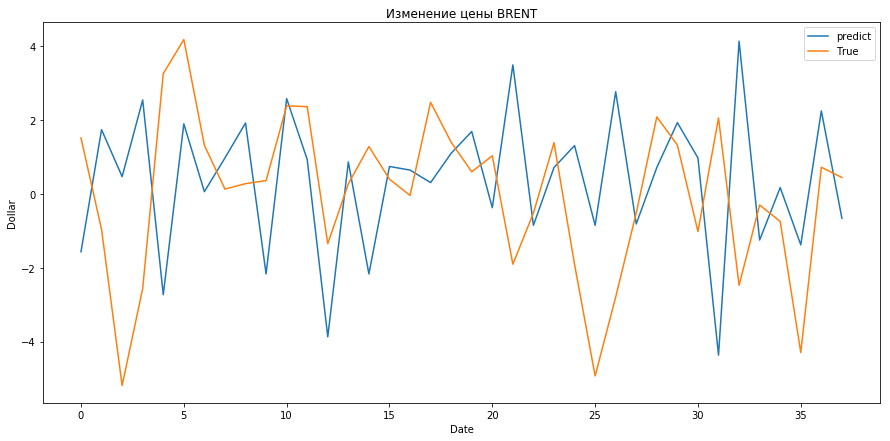

ошибка градиентного бустинга MAE :   26.96623584195719 %


In [76]:
train_d, test_d = split_data_b(df_rec.iloc[:,1], '2018-12-01')

X_train_d = train_d.iloc[:-h].values
y_train_d = train_d.iloc[h:].values
X_test_d = test_d.iloc[:-h].values
y_test_d = test_d.iloc[h:].values

model_gd = GradientBoostingRegressor(max_depth=10, random_state=0, n_estimators=1550)

scxd= StandardScaler().fit(X_train_d.reshape(y_train_d.shape[0], 1))
X_train_ds = scxd.transform(X_train_d.reshape(y_train_d.shape[0], 1))
X_test_ds = scxd.transform(X_test_d.reshape(y_test_d.shape[0], 1))

scyd= StandardScaler().fit(y_train_d.reshape(y_train_d.shape[0], 1))
y_train_ds = scyd.transform(y_train_d.reshape(y_train_d.shape[0], 1))
y_test_ds = scyd.transform(y_test_d.reshape(y_test_d.shape[0], 1))

model_gd.fit(X_train_ds, y_train_ds)


y_test_pred_ds = model_gd.predict(X_test_ds)


plt.figure( figsize=(15, 7))
plt.plot(scyd.inverse_transform(y_test_pred_ds), label='predict' )
plt.plot(scyd.inverse_transform(y_test_ds), label='True')
plt.xlabel('Date')
plt.title('Изменение цены BRENT')
plt.ylabel('Dollar')
plt.legend()
plt.show()

er_g = np.abs(scyc.inverse_transform( y_test_ds)- scyc.inverse_transform( y_test_pred_ds)).mean()

print('ошибка градиентного бустинга MAE :  ', er_g,'%')


## :) Вывод  

Прогнозное значение модели не выходит за границы изменений ряда первых разностей далеко  :

- модель ряда в первых разностях - стационарна!!!!! 
- можно предсказать диапазон случайных положений первых разностей, но не их конкретное значение. 

Такой ряд описывают его статистиками. Это случайные биения.

## Итак:
    
    - Для прогнозирования используем результаты анализа по ARIMA
    - Строим модель как можно более простую
    - Прогнозируем нестационарную часть (т.е. сглаживаем)
    - Стационарную часть описываем статистиками

---

---

---

---

---

---

---

---

---

---

---

---

---

---


# Временные ряды 4. Построение и оценка модели
##                                                              Обучаем и предсказываем

Явления во времени можно рассматривать как "черный ящик", который зависит от многих переменных.Содержание ящика нам неизвестно, но его реакции на некоторые внешние воздействия мы можем наблюдать на примерах. Если наш гипотетический котенок, которого мы выращиваем, бегает за игрушкой каждый день, то мы можем предположить, что "черный ящик - котенок" почему-то реагирует на игрушку именно беготней. Нам вообще не важно как устроен котенок, мы видим постоянное явление: достали игрушку - котенок бегает. Более того, рассматривая довольно сложное явление траекторию движений котенка, мы можем это явление представить в виде некоторого временного ряда, где координаты от времени и связаны с предшествующим положением котенка (он же не телепортируется) и экзогенными факторами (траекторией движения игрушки или количеством вусняшек в миске котенка). Если при этом мы не пробуем описать устройство котенка, а только ищем связи между измеряемыми параметрами (признаками), то мы собираемся решить задачу обучения регрессионной модели нашего явления.    

Попробуем понять, как построить модель явления во времени в такой форме. Вернемся к нашим рядам: "Потребление энергии" и "Цена нефти BRENT". Будем использовать предобработанные версии этих рядов с признаками из календаря.   

## Потребление энергии

Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

Загрузим файл с данными и посмотрим на таблицу их организующую.

In [2]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Общий вид изменения ключевого свойства ряда приведен на рис.1.

C:\Users\1\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


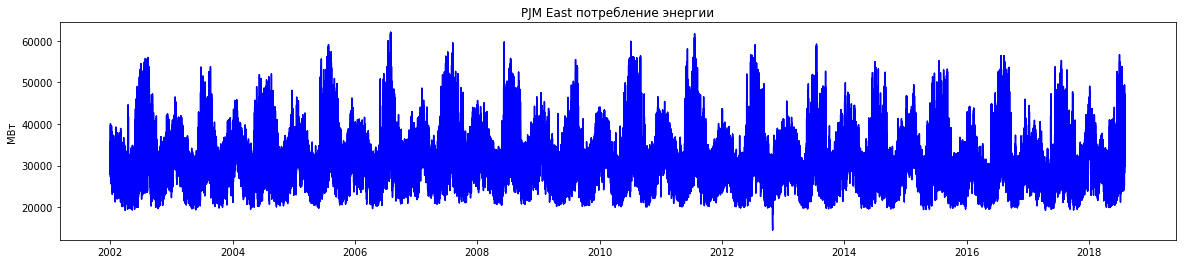

In [3]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Рис.1. Потребление энергии

## Brent 2010-2019
Перейдем ко второму примеру. Цена нефти марки Brent. Данные по дням от 2010 до 2019 . Данные были обработаны, но не меняли основное содержание ключевого признака. Отличие от исходного описания - дополнение признаками по календарю, как и в первом примере.

In [4]:

#path_brent = 'brent_cl_m5_20120101_20121231.csv'
#brent_data['Значение'] =brent_data['CLOSE']
#brent_data = pd.read_csv(path_brent,sep = ';', index_col=[0], parse_dates=[0])
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


Общий вид изменения цены по ряду приведен на рис.2.

Text(0.5, 0, 't')

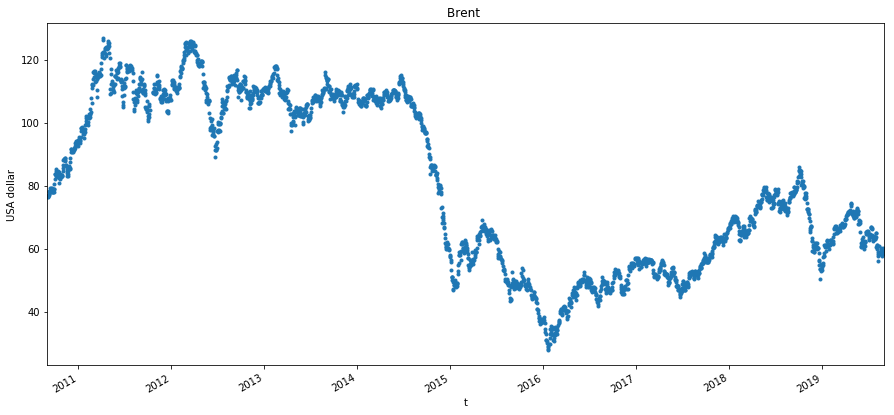

In [5]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

Рис.3 Цена нефти с 2010 по 2019

### Методы машинного обучения для анализа рядов

Попробуем построить предсказание значений наших рядов на основании исследования отдельных примеров прошлого и различных параметров окружающих наши данные (календарь, макроэкономические показатели и т.п.). Основные типы обучаемых моделей можно разобрать на 2 группы :
- модель из одного решателя (линейная регрессия, нелинейная регрессия),
- ансамбль решателей (т.е. "коллектив" функций, который вычислит общее мнение). Это, например, модели типа адаптивного бустинга.
модели с одним решателем опираются на "опыт" единственного эксперта, который наблюдает явление и запоминает исходы при различных начальных условиях и в различные моменты времени. Ансамбли генерируют группу для совместной оценки, которая строит несколько решений одновременно и объединяет их в один ответ.

Привлекательность моделей предсказания значений временных рядов на основе обучения связана с тем, что нет необходимости проводить оценку сложности неизвестной на входе в задачу модели связывающей прогнозируемую величину с ее предшествующими значениями или другими временными рядами. Фактически можно взять все, что есть в наличии и заложить в обучаемую модель как входные переменные. Практически так делать не стоит, т.к. "плохие" признаки в обучаемой модели усложнят ее и приведут к неустойчивой работе в части рабочего диапазона. Таким образом схема решения задачи прогнозирования для временных рядов в обучаемых моделях принимает вполне привычный для машинного обучения вид:
- получить исходный ряд,
- определить список экзогенных факторов (внешних по отношению к прогнозируемому ряду), которые вероятно влияют на прогноз,
- определить глубину связей внутри ряда (ACF, PACF в помощь),
- преобразовать признаки - feature engenering,
- провести анализ признаков на важность и отделить важные - feature selection,
- построить первичный набор моделей и выбрать модель для тонкой настройки,
- подобрать гиперпараметры и провести обучение финальной модели,
- оценить качество модели и вернуться к предшествующим этапам при необходимости.

Следующий вопрос , который нужно решить, касается способа извлечения прогноза. Если мы следим за траекторией движения котенка, то у нас есть 2 варианта как определить его прогнозное положение через 1 минуту:

1 ) предсказывать прямо действия котенка через 1 минуту, т.е. построить решатель f(x(t), ..,x(t-p),y(t),..,y(t-p),t) = y(t+1),x(t+1), где x(t), ..,x(t-p),y(t),..,y(t-p) - координаты котенка в последние р моментов времени и t - текущий момент, t+1 момент наблюдений, который наступит через 1 минуту и , соответственно, прогнозные координаты y(t+1),x(t+1).

2 ) предсказывать f(x(t), ..,x(t-p),y(t),..,y(t-p),t) = y(t+dt),x(t+dt), т.е. предсказывать положение через dt<1 минуты, но проделать 1/dt циклов автопрогноза, опираясь на промежуточные y(t+dt),x(t+dt) , до достижения заданного горизонта прогнозирования.

**Спрашивается, какая тактика приносит успех?** Понятно, что чем дальше прогнозируемая точка, тем больше ошибка прогноза. Если мы попробуем предсказать, где будет котенок через 10 минут, вероятность угадать может быть близкой к 0. С другой стороны, если поведение объекта циклично, то наши шансы на успех значительно вырастут. Поэтапное прогнозирование на небольшом промежутке предсказания, хотя бы сначала, будет давать лучшее решение, т.к. короче интервал прогноза. Однако попадание в точку желаемого горизонта прогноза потребует применить f(x(t), ..,x(t-p),y(t),..,y(t-p),t) = y(t+dt),x(t+dt) 1/dt раз, что приводит к потере времени и накоплению ошибок.

Таким образом, следует обратиться к содержанию задачи прогнозирования и определить, уровень допустимой ошибки и что важнее в конкретных условиях: непрерывность решения (вариант 2) или получение конкретной точки (вариант генерации прогноза 1).

Рассмотрим построение модели прогнозирования точек ряда для наших рабочих примеров.


## Генерация признаков

Построение признаков во временных рядах значительно зависит от семантики ряда и его проблемной области. Например, если мы пытаемся предсказывать биржевые показатели, то очевидно, что наш ряд зависит от календаря и внешних экономических причин (экзогенных факторов), которые никаким способом извлечь из самого ряда не выйдет. Другой случай, короткое предсказание аудиосигнала при обработке звука. Звук непрерывен и имеет выраженный периодический характер, что позволяет использовать новые признаки - коэффициенты спектрограмм или результаты вейвлет-анализа. Обычно, конечно , для звуковых рядов решают не задачу предсказания, а задачу оценки-классификации. Это еще один аспект анализа временных рядов, о котором поговорим в следующей теме. Однако, очевидно, что признаки, которые отлично сработают в одних рядах и задачах не сработают в других, внешне похожих, ситуациях. Будем рассматривать признаки влияние, которых на прогнозирование обычно положительно.

Первый слой таких признаков мы уже построили - это признаки из календаря, которые позволяют увязывать сезоны, дни недели и часы дня. Выберем в качестве горизонт прогнозирования ряда "Потребление энергии" - среднее потребление в день на 1 день вперед. Это подразумевает, что часовая точность ряда нам не нужна. Сделаем ресемплинг на дни


In [6]:
data_d = data.copy().resample('D').mean()
data_d.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-01,31080.739130,2002.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,1.0,0.0,0.0
2002-01-02,34261.541667,2002.0,1.0,2.0,1.0,2.0,1.0,2.0,11.5,0.0,0.0,1.0
2002-01-03,34511.875000,2002.0,1.0,3.0,1.0,3.0,1.0,3.0,11.5,0.0,0.0,0.0
2002-01-04,33715.458333,2002.0,1.0,4.0,1.0,4.0,1.0,4.0,11.5,0.0,0.0,0.0
2002-01-05,30405.125000,2002.0,1.0,5.0,1.0,5.0,1.0,5.0,11.5,0.0,0.0,0.0


Удалим данные о часах, т.к. они потеряли актуальность

In [7]:
data_d.drop('hour', axis=1,inplace=True)
data_d.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,
2002-01-01,31080.739130,2002.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2002-01-02,34261.541667,2002.0,1.0,2.0,1.0,2.0,1.0,2.0,0.0,0.0,1.0
2002-01-03,34511.875000,2002.0,1.0,3.0,1.0,3.0,1.0,3.0,0.0,0.0,0.0
2002-01-04,33715.458333,2002.0,1.0,4.0,1.0,4.0,1.0,4.0,0.0,0.0,0.0
2002-01-05,30405.125000,2002.0,1.0,5.0,1.0,5.0,1.0,5.0,0.0,0.0,0.0


Категорийные признаки ['year','month','dayofmonth','quarter','dayofyear','weekofyear','dayofweek'] не стоит превращать в dummy-переменную, т.к. это приведет к значительному увеличению базы.
Поскольку в годовом развороте ряда тренда нет (временные ряды 2 и 3), то признак 'year' можно исключить.


In [8]:
data_d.drop('year', axis=1,inplace=True)

Можно построить интегральный признак используя кластеранализ или частичную классификацию. Начнем с признака по кластеранализу. Воспользуемся методом kmeans, если можем предположить сколько будет кластеров, или DBSCAN, который не требует знания реального числа кластеров. 

In [9]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
import seaborn as sns

scl=StandardScaler()
tsne_ =TSNE(n_components=2)

X = data_d.iloc[:,:-1].values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)



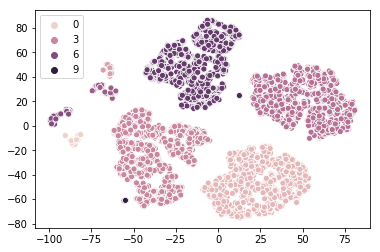

In [10]:
clast_0 = DBSCAN(eps=5, leaf_size=15 )
clast_1 = DBSCAN(eps=2, leaf_size=5)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

Рис.3. Результат кластер-анализа признаков

In [11]:
print('Число кластеров в календаре с масштабированием: ',len(np.unique(X_scale_clast)))
print('Число кластеров в календаре: ',len(np.unique(X_clast)))

Число кластеров в календаре с масштабированием:  9
Число кластеров в календаре:  10


Вариант кластеризации с разметкой на рис.3 для случая масштабированных коордимнат показывает отлично выделяемые кластеры с хорошим размещением объектовтов по группам. Принадлежность кластерам можно использовать в качестве нового признака и проверить качество обработки модели с новой координатой. В данном конкретном примере кластеризация без масштабирования, но с понижением размерности выглядит очень обосновано. Берем этот вариант за основу и добавим признак к общему описанию задачи. 

In [12]:
data_d['day_week_month'] = X_clast
data_d.iloc[np.where(data_d['day_week_month']==0)[0]].iloc[:10,:]

,PJME_MW,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,day_week_month
Date,,,,,,,,,,,
2002-01-01,31080.739130,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0
2002-01-21,32434.916667,1.0,21.0,1.0,21.0,4.0,0.0,1.0,0.0,0.0,0
2002-02-18,30929.125000,2.0,18.0,1.0,49.0,8.0,0.0,1.0,0.0,0.0,0
2002-05-27,26089.416667,5.0,27.0,2.0,147.0,22.0,0.0,1.0,0.0,0.0,0
2003-01-01,27603.708333,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,0
2003-01-20,35501.500000,1.0,20.0,1.0,20.0,4.0,0.0,1.0,0.0,0.0,0
2003-02-17,35268.625000,2.0,17.0,1.0,48.0,8.0,0.0,1.0,0.0,0.0,0
2003-05-26,24095.833333,5.0,26.0,2.0,146.0,22.0,0.0,1.0,0.0,0.0,0
2004-01-01,27885.250000,1.0,1.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0,0


В выборке объектов типа 0 собраны праздничные дни, а в типе 2 нового признака собрали дни первого квартала, кроме праздников.

In [13]:
data_d.iloc[np.where(data_d['day_week_month']==2)[0]].iloc[:10,:]

,PJME_MW,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,day_week_month
Date,,,,,,,,,,,
2002-01-20,29482.916667,1.0,20.0,1.0,20.0,3.0,6.0,0.0,1.0,0.0,2
2002-02-17,26883.250000,2.0,17.0,1.0,48.0,7.0,6.0,0.0,1.0,0.0,2
2002-05-26,24351.500000,5.0,26.0,2.0,146.0,21.0,6.0,0.0,1.0,0.0,2
2003-01-19,34429.750000,1.0,19.0,1.0,19.0,3.0,6.0,0.0,1.0,0.0,2
2003-02-16,35948.000000,2.0,16.0,1.0,47.0,7.0,6.0,0.0,1.0,0.0,2
2003-05-25,23621.875000,5.0,25.0,2.0,145.0,21.0,6.0,0.0,1.0,0.0,2
2003-08-31,28198.541667,8.0,31.0,3.0,243.0,35.0,6.0,0.0,1.0,0.0,2
2004-01-18,33026.291667,1.0,18.0,1.0,18.0,3.0,6.0,0.0,1.0,0.0,2
2004-02-15,31169.500000,2.0,15.0,1.0,46.0,7.0,6.0,0.0,1.0,0.0,2


Другой путь получения новых признаков применение преобразований для понижения размерности. Пример такого преобразования приведен выще в процессе построения признака из кластерного анализа , использовали редукцию пространства с использованием модели t-SNE. Однако, эта модель характерна высокой вычислительной сложностью, что увеличивает время решения задачи. Более простая, хотя и линейная модель, это PCA - метод главных компонент. Поскольку наши координаты календаря вполне связаны, то можно проверить и такой путь объединения признаков. Добавим признак на основе компонетного анализа. Построим 2 компоненты по признакам из календаря , без значений ряда и допишем их в общую таблицу data_d.

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:])
Xpca.shape

(6059, 2)

In [15]:
data_d['pca1']=Xpca[:,0]
data_d['pca2']=Xpca[:,1]

Добавим новых признаков, описывающих содержание ряда. К таким признакам можно отнести разности ряда и разнообразные варианты сглаживания. Добавим к нагшей модели 1-е разности. При этом следует помнить, что такие операции уменьшают общуюю длину корректной выборки на 1, т.е. первую строку данных следует исключить из модели в момент обучения.

In [16]:
first_diff =data_d.iloc[1:,0].values - data_d.iloc[:-1,0].values 
data_d['diff1'] = 0
data_d['diff1'].values[1:] = first_diff

Добавим скользящее среднее по всей модели с глубиной 7 дней. Размер окна определен длиной недельных циклов.

In [17]:
data_d['d_w7']=data_d['PJME_MW'].rolling(window=7).mean()

А теперь добавим еще и экспонентциальную среднюю. Медленную, т.к. интересная информация лежит на уровне сезонных колебаний цены.

In [18]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

data_d['exp_0_05'] = exponential_smoothing(data_d['PJME_MW'], 0.05)


В итоге данные примут вид 

In [19]:
data_d.iloc[10:15,:]


,PJME_MW,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,day_week_month,pca1,pca2,diff1,d_w7,exp_0_05
Date,,,,,,,,,,,,,,,,
2002-01-11,30947.541667,1.0,11.0,1.0,11.0,2.0,4.0,0.0,0.0,0.0,1,-3.090058,-0.351464,-524,32088.672619,31698.654162
2002-01-12,28466.875000,1.0,12.0,1.0,12.0,2.0,5.0,0.0,0.0,0.0,1,-3.081461,-0.699271,-2480,31811.779762,31537.065204
2002-01-13,28052.833333,1.0,13.0,1.0,13.0,2.0,6.0,0.0,0.0,0.0,1,-3.072864,-1.047078,-414,31487.386905,31362.853610
2002-01-14,31602.958333,1.0,14.0,1.0,14.0,3.0,0.0,0.0,0.0,0.0,1,-3.032802,0.982834,3550,31240.119048,31374.858846
2002-01-15,31223.791667,1.0,15.0,1.0,15.0,3.0,1.0,0.0,0.0,0.0,1,-3.024205,0.635026,-379,30791.672619,31367.305487


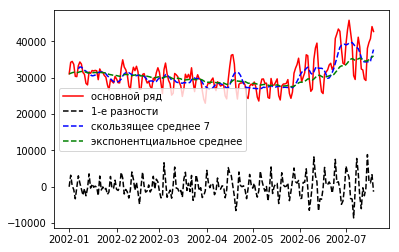

In [20]:
N100=200
plt.plot(data_d.index[:N100],data_d['PJME_MW'][:N100],'r',label ='основной ряд')
plt.plot(data_d.index[:N100],data_d['diff1'][:N100],'--k',label ='1-е разности')
plt.plot(data_d.index[:N100],data_d['d_w7'][:N100],'--b',label ='скользящее среднее 7')
plt.plot(data_d.index[:N100],data_d['exp_0_05'][:N100],'--g',label ='экспонентциальное среднее')
plt.legend()
plt.show()


Проблема состоит в том, что подобных признаков можно построить бесконечное количество. Для определения разумных интервалов имеет смысл вспомнить результаты анализа ряда в статистических моделях. Период сезонных колебаний 13 недель и недельный цикл по дням. Это позволит не строить все возможные сочетания параметров модели, а сократить их число до относительно небольшого подмножества. Посмотрим на примере экспонентциальных средних в диапазоне alpha = [0.3, 0.8] 

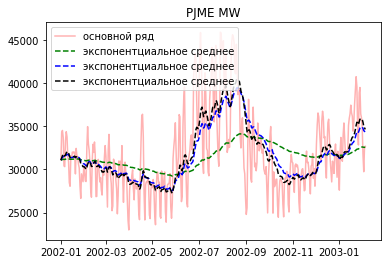

In [25]:
data_d['exp_0_01'] = exponential_smoothing(data_d['PJME_MW'], 0.01)
data_d['exp_0_03'] = exponential_smoothing(data_d['PJME_MW'], 0.03)
data_d['exp_0_04'] = exponential_smoothing(data_d['PJME_MW'], 0.04)
data_d['exp_0_06'] = exponential_smoothing(data_d['PJME_MW'], 0.06)
data_d['exp_0_07'] = exponential_smoothing(data_d['PJME_MW'], 0.07)
data_d['exp_0_08'] = exponential_smoothing(data_d['PJME_MW'], 0.08)

N100=400
plt.plot(data_d.index[:N100],data_d['PJME_MW'][:N100],'r',label ='основной ряд',alpha=0.3)
plt.plot(data_d.index[:N100],data_d['exp_0_01'][:N100],'--g',label ='экспонентциальное среднее')
plt.plot(data_d.index[:N100],data_d['exp_0_05'][:N100],'--b',label ='экспонентциальное среднее')
plt.plot(data_d.index[:N100],data_d['exp_0_08'][:N100],'--k',label ='экспонентциальное среднее')
plt.legend()
plt.title('PJME MW')
plt.show()

In [81]:
data_d.iloc[:7,14]=0

Добавим истории длиной p в признаках автокорреляции

In [31]:
p = 7
for i in range(p):
    data_d['t'+str(p-i)]=0
    data_d['t'+str(p-i)].values[p:] = data_d['PJME_MW'].values[i:-(p)+i]

Аналогично добавляем первые разности

In [34]:
p = 7
for i in range(p):
    data_d['d'+str(p-i)]=0
    data_d['d'+str(p-i)].values[p:] = data_d['diff1'].values[i:-(p)+i]

Итоговая система признаков

In [35]:
data_d.head(10)

,PJME_MW,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,...,t6,t5,t4,d7,d6,d5,d4,d3,d2,d1
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,31080.739130,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2002-01-02,34261.541667,1.0,2.0,1.0,2.0,1.0,2.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2002-01-03,34511.875000,1.0,3.0,1.0,3.0,1.0,3.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2002-01-04,33715.458333,1.0,4.0,1.0,4.0,1.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2002-01-05,30405.125000,1.0,5.0,1.0,5.0,1.0,5.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2002-01-06,30323.583333,1.0,6.0,1.0,6.0,1.0,6.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2002-01-07,33333.833333,1.0,7.0,1.0,7.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2002-01-08,34362.916667,1.0,8.0,1.0,8.0,2.0,1.0,0.0,0.0,0.0,...,34261,34511,33715,0,3180,250,-796,-3310,-81,3010
2002-01-09,33776.166667,1.0,9.0,1.0,9.0,2.0,2.0,0.0,0.0,0.0,...,34511,33715,30405,3180,250,-796,-3310,-81,3010,1029


## Выделение существенных признаков

Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1) 

In [37]:
scl_target=StandardScaler() 
# p = 7
h=1
target = data_d['PJME_MW'].values[h+p:].reshape((data_d.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(6051, 1)

Входной набор признаков берем из нашей таблицы. Необходимо помнить, что у нас есть интегральные признаки (для календаря), которые связаны с базовыми признаками. Обычно такие признаки рассматривают отдельно. Однако для эксперимента оставим все признаки для процедуры селекции.

In [38]:
scl_x=StandardScaler() 

X = data_d.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(6051, 30)

In [78]:
X[:7,14]=0

Размеры выборок по строкам совпали. Мы взяли на h строк меньше для Х и на h значений позднее по target. Таким образом, входной набор данных сформирован.

Как и во всех задачах обучения, системах признаков не идеальна. Есть признаки хорошие, а есть признаки плохие. Применим механизмы  селекции признаков для нашей модели. 
Рассмотрим механизмы селекции специфичные для регрессий и доступные из scikit-learn. Это два основных способа селекции: 
- построим или применим метрику взвещивающую связь признака и целевого свойства,
- проведем предварительное обучение и проверим влиятельность признаков по результатам такого обучения.

Такое решение задачи селекции признаков поддерживается через SelectKBest (отбираем k лучших признаков), SelectPercentile (отбираем заданный процент признаков) и SelectFromModel, соответственно(https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). Посмотрим на результаты оценки нашей системы признаков.

In [39]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)
for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))


F-test=1.00,  I=0
F-test=0.00,  I=1
F-test=0.00,  I=2
F-test=0.00,  I=3
F-test=0.00,  I=4
F-test=0.00,  I=5
F-test=0.01,  I=6
F-test=0.00,  I=7
F-test=0.00,  I=8
F-test=0.00,  I=9
F-test=0.01,  I=10
F-test=0.00,  I=11
F-test=0.01,  I=12
F-test=0.05,  I=13
F-test=0.45,  I=14
F-test=0.24,  I=15
F-test=0.29,  I=16
F-test=0.18,  I=17
F-test=0.15,  I=18
F-test=0.19,  I=19
F-test=0.27,  I=20
F-test=0.21,  I=21
F-test=0.15,  I=22
F-test=0.01,  I=23
F-test=0.01,  I=24
F-test=0.00,  I=25
F-test=0.01,  I=26
F-test=0.00,  I=27
F-test=0.00,  I=28
F-test=0.01,  I=29


Проверка через F-test показывает, что есть корреляционная связь с предшествующим значением ряда (признак X[:,0]), а кроме этого интересные признаки  от 14 до 21. Применим автоматизацию выбора через SelectKBest c выделением 5 лучших признаков.

In [40]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(6051, 5)

In [45]:
column_names = data_d.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 'd_w7', 'exp_0_05', 't1', 't6'], dtype='object')

In [43]:
X_new1[:1,:]

array([[ 0.48714363,  0.22890241, -0.13579214,  0.2678672 ,  0.46626331]])

Лучшее множество признаков отделено в X_new1. Проверим результат оценки признаков по процентному отбору и сохраним его в X_new2.

In [41]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(6051, 3)

In [46]:
column_namesp = data_d.columns[sfp.get_support()]
column_namesp

Index(['PJME_MW', 'd_w7', 't1'], dtype='object')

Наконец, третий вариант - применим выделение признаков через построение модели. Помним, что модель должна уметь выбрать подмножество признаков или вернуть коэффициент их влиятельности. Это ограничивает выбор моделей. Возьмем как оценшик GradientBoostingRegressor и построим новое пространство в X_new3

In [47]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(6051, 2)

Сравним результаты:


In [48]:
[X_new1[:5,:], X_new2[:5,:],X_new3[:5,:]]

[array([[ 0.48714363,  0.22890241, -0.13579214,  0.2678672 ,  0.46626331],
        [ 0.36200489,  0.21148239, -0.10136657,  0.48737177,  0.51960184],
        [-0.1295126 ,  0.10236538, -0.10590196,  0.36236723,  0.34977195],
        [-0.24126838,  0.00302536, -0.11867774, -0.12933155, -0.35643025],
        [-0.77033105, -0.06653808, -0.17089901, -0.24111036, -0.37392529]]),
 array([[ 0.48714363,  0.22890241,  0.2678672 ],
        [ 0.36200489,  0.21148239,  0.48737177],
        [-0.1295126 ,  0.10236538,  0.36236723],
        [-0.24126838,  0.00302536, -0.12933155],
        [-0.77033105, -0.06653808, -0.24111036]]),
 array([[ 4.87143634e-01, -9.99896738e-01],
        [ 3.62004886e-01, -4.99824404e-01],
        [-1.29512603e-01,  2.47928772e-04],
        [-2.41268383e-01,  5.00320262e-01],
        [-7.70331051e-01,  1.00039260e+00]])]

In [50]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 14 15 16 20]
Номера признаков лучших признаков по процентной форме:  [ 0 14 16]
Номера признаков для выбора по модели :  [0 6]


Пересечение выбора по отбору для модели и по количественным оценкам связи в признаке 0. Имеет смысл брать объединение выборов. Возьмем [0,6,14,21] признаки и перейдем к построению модели.

In [82]:
list_par=[0,6,14,15,16,20]
X_new = X[:,list_par]
data_d.columns[list_par]

Index(['PJME_MW', 'dayofweek', 'd_w7', 'exp_0_05', 't1', 't6'], dtype='object')


## Разделение данных на тестовые и тренировочные 

Построение модели начинаем с выделения тестовой части нашего ряда. Напомним, что для временных рядов тест - непрерывная часть ряда не входившая в обучение (временные ряды 1). Будем отделять по индексу, который задаст дату разделения модели на тест и обучение.

In [52]:
# сделаем функцию
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

Для временного ряда "Потребление энергии" назначим датой разделения 1/06/2016

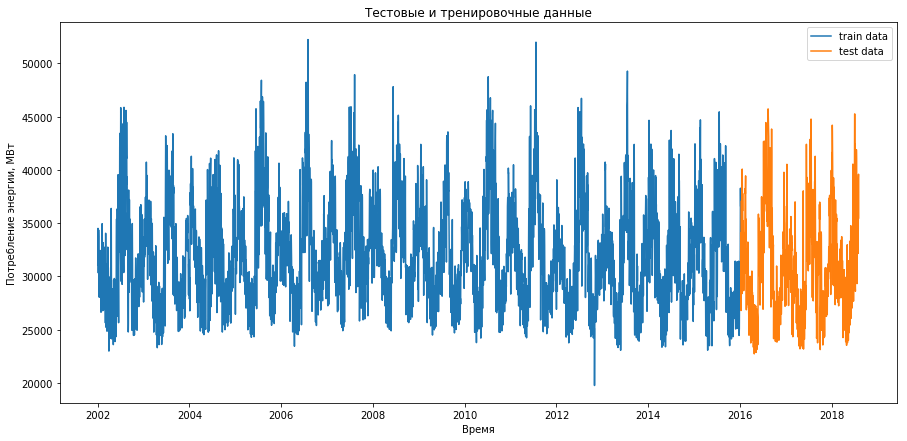

In [53]:
train, test = split_data( data_d, '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [54]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [55]:
train.shape

(5119, 30)

Выделим описание объекта и целевое свойство для тестовой и тренировочной частей ряда. Перейдем к построению моделей.  

# Строим Модель

При решении задачи на начальном этапе, самый интересный результат был получен на модели GradientBoostingRegressor. Остановимся на построении иенно такой формы предсказания. Импортируем необходимые модели.

In [56]:
from sklearn.ensemble import GradientBoostingRegressor

In [58]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

Запускаем модели и смотрим , что они построят на наших примерах.

In [59]:
model_g.fit( X_train, y_train ) # 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

**Посмотрим тесты**

In [60]:
X_test.shape

(932, 6)

In [61]:
y_test_pred_g = model_g.predict(X_test)

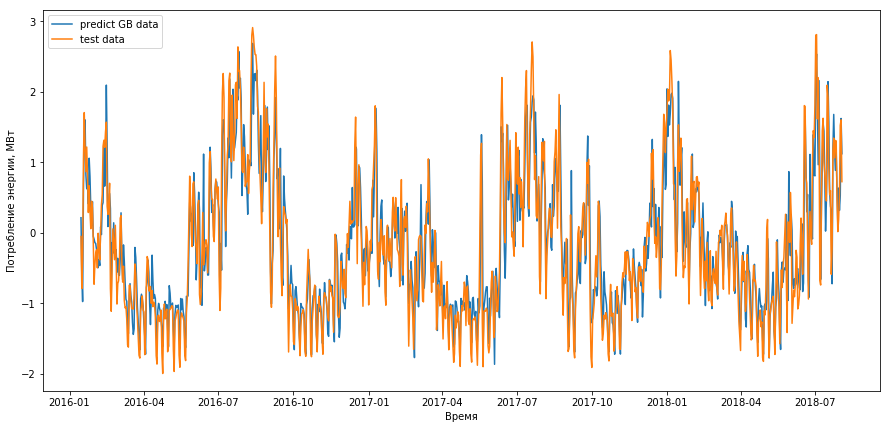

In [63]:

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

**Оценки для сравнения моделей**

Оценим промах модели, используя метрики, которые можно применять для оценки регрессий https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics:
- средне-квадратичное отклонение
- среднюю абсолютную ошибку
- коэфиициент детерминации 

In [64]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [65]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.17251106638834035 
ошибка mae  :   0.31507106405881247 
оценка R2 :   0.8345534160072265


Абсолютная процентная ошибка (MAPE).Обратите внимание, что определять ее для масштабированной переменной не верно. Пожэтому переведем ответ решателя обратно в состояние без масштаба.

In [66]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [67]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   4.695070006700913 %


Ошибка неплоха, но мы имеем дело с маленьким горизонтом прогноза и тем неменее пока точность предсказания не превышает 96%. 
Построим более точную модель с использованием поиска моделей. Воспользуемся методом поиска 

In [70]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.849 (std: 0.011)
Parameters: {'n_estimators': 300, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.848 (std: 0.011)
Parameters: {'n_estimators': 200, 'max_depth': 2}

Model with rank: 3
Mean validation score: 0.847 (std: 0.013)
Parameters: {'n_estimators': 100, 'max_depth': 3}



Выбираем модель с рангом 1. {'n_estimators': 300, 'max_depth': 2} и проведем ее обучение на тренировочном наборе.

In [71]:
model_g_best = GradientBoostingRegressor(max_depth=2,  n_estimators=300)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   4.6563742802549015 %


Качество решения задачи по MAPE повысилось почти на 0.04%. Очевидно, что диапазон вариаций значений был довольно узким и есть возможность поискать решение в более широком выборе параметров и их значений. Кроме того, провели всего 10 итераций поиска, что также не позволяет гарантировать идеальный ответ. Однако даже в такой версии за несколько минут поиска удается улучшить результат исходной модели. 

## Сохраниение модели

In [72]:
import pickle
# save the model to disk
filename = 'final_model.sav'
pickle.dump(model_g_best, open(filename, 'wb'))

filename = 'final_scaler_y.sav'
pickle.dump(scl_target, open(filename, 'wb'))

filename = 'final_scaler_x.sav'
pickle.dump(scl_x, open(filename, 'wb'))


## Использование модели для предсказания n*h моментов времени

Мы построили короткий прогноз, но его можно продолжить на следующие точки ряда. Для этого будем использовать результаты прогноза для следующего шага.  Необходимо заменять X_test[t+i, 0] = y_test[t+i-1] и продолжить моделирование в новом состоянии. Сделаем 10 дней прогноза.

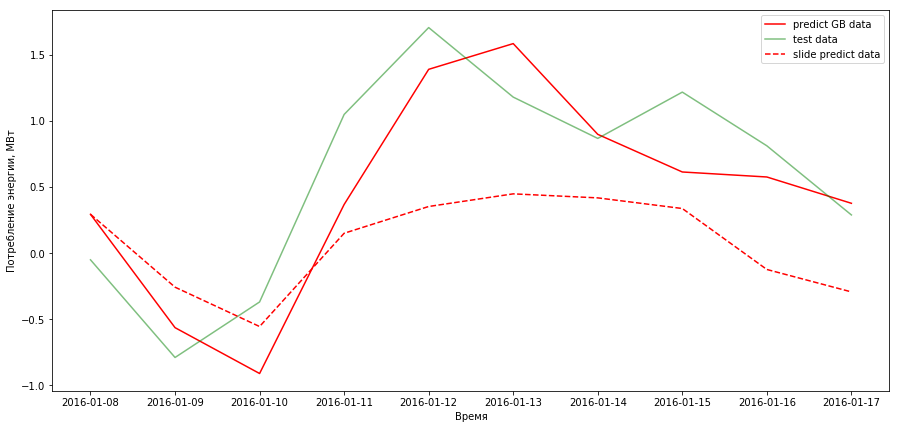

In [89]:
#['PJME_MW', 'dayofweek', 'd_w7', 'exp_0_05', 't1', 't6']
X_test_100 = X_test.copy()
y_test_100 = y_test_pred_g.copy()
N10 = 10
for i in range(N10):
    y_test_100[i] = model_g_best.predict(X_test_100[i,:].reshape((1,6)))
    X_test_100[i+1,0] = y_test_100[i]
    X_test_100[i+1,4] = X_test_100[i,0]
    if i>4:
        X_test_100[i+1,5] = X_test_100[i-5,0]
        
    
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')

plt.legend()
plt.show()    

In [90]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[:N10]),y_pred = scl_target.inverse_transform( y_test_100[:N10]))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   9.016852032873295 %


Ошибка прогнозирования выросла до 9%. Однако, мы предсказываем на 10 дней вперед, что само по себе достаточно сложно для любой модели. Промах нарастает с глубиной предсказания. Однако, тенденция прослеживается и на горизонте 10 дней вперед. Таким образом, построили модель однодневных прогнозов и протянули ее на более днинный интервал за счет авторекурсивного обращения к значениям ряда. В простом алгоритме рекурсии следует учесть и изменение скользящих средних, которые не обработаны сейчас. Это потребует обновления не только признака X[:,0], но и признаков 3 и 4, 5 финальной модели ( 3-й - ''exp_0_05'',а  4-й и 5-й -	't1', 't6'  - признаки модели до селекции). Это конечно требует некоторых усилий при организации обработки, но можно получить неплохой результат на довольно длинном периоде прогнозирования. Помимо этого, мы построим прогноз для каждой точки ряда, а не только для точки h на глубине прогнозирования.

## Заключение

Прогнозирование на основе обучения позволяет эффективно описывать достаточно сложные данные. Построение прогноза на основе генерации регрессионных моделей позволит построить хороший ответ даже не зная как устроен ряд и каковы его статистические свойства. При решении задачи прогнозирования следует учитывать следующие особенности этого подхода:
- Строим много признаков.
- Обрабатываем признаки и используем результаты статистического анализа ряда для придумывания новых признаков.
- Стироим много моделей и не забываем, что тестирование моделей идет только на последних точках ряда.
- Используем правильные метрики.
- Используем авторекурсивную модель.



## Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты моделирования ARIMA.
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты моделирования ARIMA.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки bp 4-х точек. 
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

***

---

***

---

***

---

***

---

***

---

***

---

***

---

# Временные ряды 5. Поиск аномалий и особенные случаи обработки  

Временные ряды - процесс, который идет шаг за шагом. Порядок постоянен или предсказуем.Однако, иногда что-то идет не так. Котенок не  бегает за бантиком. Вопрос - это только сегодня или теперь так будет всегда? Если всегда, то идем менять модель (кот вырос). Если только сейчас, то это аномалия. Аномалии интересны, но опасны.

Попробуем разобраться аномалиями. Вспомним пример аварии в потреблении энергии и попробуем его узнать автоматически.      


## Потребление энергии

Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

C:\Users\1\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Загрузим файл с данными и посмотрим на таблицу их организующую.

In [319]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.index = pd.to_datetime(data.index.astype('str')+' '+data['Time'].astype('str'))
data.sort_index(inplace=True)
data.drop('Time',axis=1, inplace =True)
data.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Общий вид изменения ключевого свойства ряда приведен на рис.1.

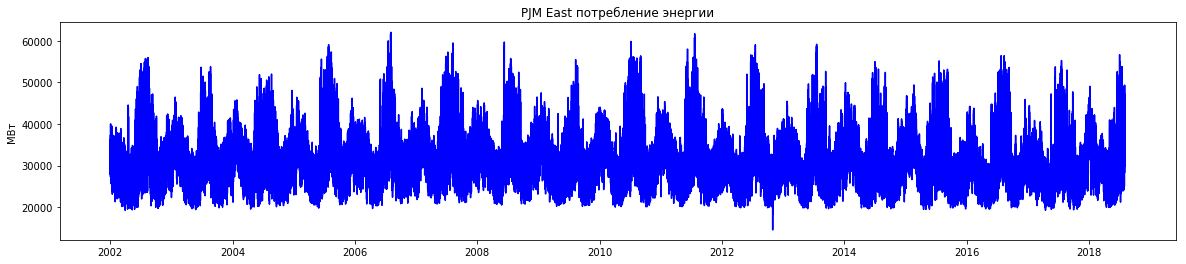

In [320]:
data['data_time']=data.index
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Рис.1. Потребление энергии


Наша цель лежит между 2012 и 2014 годом. Интуитивно понятно, что дело в уровне. Начнем с постановки задачи.

## Задача обнаружения аномалий ##

Для заданного множества объектов необходимо получить множество-исключение. 

С точки зрения временных рядов мы получаем следующее представление:
- Х - вектор наблюдения состоит из измерений временного ряда, а его длина соответствует ширине окна анализа.
- отклонение статистической характеристики вектора от остальных векторов можно считать аномалией. 


Основные задачи:
1.  Задача  распознавания  аномалий,  вытекающих  из  контекста  наблюдаемого  процесса.
2.  Задача  выделения  аномальных  участков  и  дифференциация  аномалий  от  шумов.
3.  Задача  распознавания  аномалий  путем  сравнения  идеальных  и  реальных  процессов.


**Типы аномалий**

Если анализировать только случайную компоненту, то многие аномалии можно свести к одному из следующих случаев:

***Выброс в данных временного ряда.*** Существенное амплитудное изменение ряда на коротком интервале. Классическая задача - работает правило трех сигм, межквартильный размах и другие.

***Изменение характера (распределения) значений.*** Движения временного ряда, связанные с редко происходящими событиями, имеющие скачкообразный характер и меняющие тенденцию. Эту часть предсказывать без внешней информации затруднительно.

***Отклонение от «повседневного» (для данных с циклом)*** Сравниваем текущий период и несколько предыдущих и оцениваем разницу. 

**Основные подходы к поиску аномалий**

- ***Метод  скользящего  окна***.  Ряд  разбивается  на  участки  (окна). Поиск  аномальной  подпоследовательности  осуществляется  при  помощи  скольжения  окна  по  всему  ряду  с  шагом  меньшим  длины  окна  ( размер  окна  должен  нужно подобрать в эксперименте или задать на основе опыта,  увеличение  размера и числа окон  быстро повышают  вычислительную  сложность  алгоритма).  Метод  является  самым  универсальным,  и  применим  для  любых  типов рядов.


- ***Кластеризация***. Строит группировки измерений. Нет  представления  о  точности  границ  аномалий, пропускает  незначительные  аномалии. Универсальный  метод  поиска  аномалий.


- ***Статистические  методы***.  Используют  критерии  для  проверки  гипотез  о  сходстве  или  различии  двух  выборок.  Корреляционный  анализ между частями ряда может  служить  для  анализа  аномальности.  Хорошо работает в задачах  поиска  аномалий  в  физических  процессах. Анализ путём поиска представителей, которые меньше подходят к остальному набору данных.  

- ***Обнаружение аномалий основанное на модели регрессии временного ряда***. Наложив модель на данные, можно спрогнозировать тенденции, а затем проверить, все ли показатели соответствуют им. Для этого нужно сравнить спрогнозированные и фактические показатели. Значительная разница укажет на отклонение или аномалию.

 
- ***Выявления аномалий с учителем***. Требует предоставления данных, помеченных как «нормальные» и «ненормальные», и использует обучение классификатора (выборка очень несбалансирована). 


Посмотрим как применить различные техники поиска аномалий к нашему ряду. Разберем ряд на вектора и определим параметры распределения.

## Статистический подход

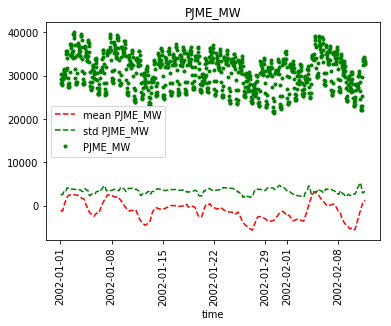

In [321]:
h = 24
mean_d=[]
std_d=[]

MeanT=np.mean(data['PJME_MW'])

for i in range(1000):
    d = data['PJME_MW'].iloc[i:i+h] - MeanT
    mean_d.append(np.mean(d))
    std_d.append(np.std(d))
plt.plot(data['data_time'].iloc[:1000],mean_d,'--r',label='mean PJME_MW')    
plt.plot(data['data_time'].iloc[:1000],std_d,'--g',label='std PJME_MW') 
plt.plot(data['data_time'].iloc[:1000],data['PJME_MW'].iloc[:1000],'.g',label='PJME_MW')
plt.title('PJME_MW')
plt.legend()
plt.xlabel('time')
plt.xticks(rotation='90')
plt.show()

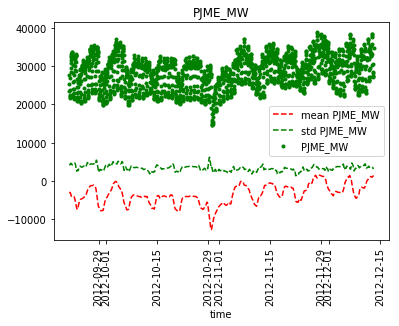

In [322]:
h = 24
T=24*365*11-24*100
mean_da=[]
std_da=[]
for i in range(2000):
    da = data['PJME_MW'].iloc[T+i:T+i+h] - MeanT
    mean_da.append(np.mean(da))
    std_da.append(np.std(da))
std_da = np.array(std_da)
plt.plot(data['data_time'].iloc[T:2000+T],mean_da,'--r',label='mean PJME_MW')    
plt.plot(data['data_time'].iloc[T:2000+T],std_da,'--g',label='std PJME_MW') 
plt.plot(data['data_time'].iloc[T:2000+T],data['PJME_MW'].iloc[T:2000+T],'.g',label='PJME_MW')
plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()

На графике виден провал (ураган?). Кроме провала в основном ряду виден всплеск в ряду стандартных отклонений и провал в ряду средних. Можно построить простой тест: сглаживание - 1 день, D = |std_da[j]-mean[std_a]| > std_porog. Порог подберем по известной аномалии. В итоге получили метку для аномалии. Можем расчитывать, что и другие аномалии найдем. Порог определен по разбросу стандартных отклонений ряда std_da (стандартное отклонение для стандартного отклонения), а коэффициент (80) результат подбора по известному факту аномалии.

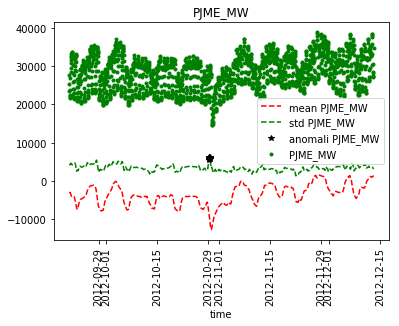

In [44]:

# порог - подобрали по известной аномалии
porog_ = np.abs(std_da - np.mean(std_da)) > (np.std(std_da)**0.5)*80
ind_ = np.where(porog_==1)[0]
plt.plot(data['data_time'].iloc[T:2000+T],mean_da,'--r',label='mean PJME_MW')    
plt.plot(data['data_time'].iloc[T:2000+T],std_da,'--g',label='std PJME_MW') 
plt.plot(data['data_time'].iloc[T:2000+T][ind_],std_da[ind_],'*k',label='anomali PJME_MW') 
plt.plot(data['data_time'].iloc[T:2000+T],data['PJME_MW'].iloc[T:2000+T],'.g',label='PJME_MW')
plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()

Поиск аномалий подобным образом основан на прецедентах и может быть реализован как классификатор, если есть разметка. 

## Скользящее окно

Очевидно, что средняя во времени может изменяться. Таким образом имеет смысл смотреть на сглаженые модели ряда  или на скользящие средние, которые позволяют моделировать основные тенденции ряда, его сезонность(цикличность) с тем, чтобы увидеть истинные статистические характеристики конкретного отрезка ряда. Сделаем сглаживание по среднему на дневные интервалы и месячные циклы сезона.

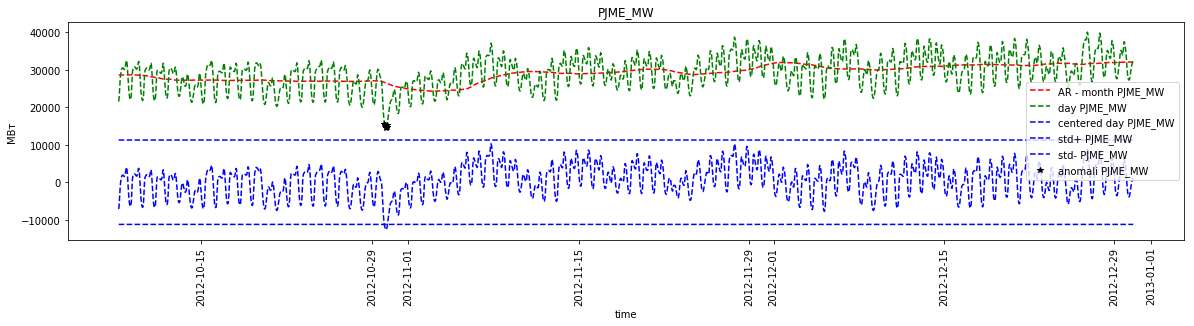

In [45]:
data_m=data['PJME_MW'].rolling(24*30).mean()
diff_day = data['PJME_MW'].rolling(2).mean()#-data_m
data_d=data['PJME_MW'].rolling(24*7).mean()
#data_d[np.where(np.abs(data_d)<0.0001)[0]]=data_d.mean()
diff_day_month=diff_day-data_m
sigma3_diff_day_month = diff_day_month.std()*2

porog_ = np.abs(diff_day_month[-51000:-49000]) > sigma3_diff_day_month 
ind_ = np.where(porog_==1)[0]

plt.figure(figsize =(20,4))
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.plot(data['data_time'].iloc[-51000:-49000],data_d[-51000:-49000],'--r',label='AR - month PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day[-51000:-49000],'--g',label='day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day_month[-51000:-49000],'--b',label='centered day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],[-sigma3_diff_day_month]*2000 ,'--b',label='std+ PJME_MW')

plt.plot(data['data_time'].iloc[-51000:-49000],[sigma3_diff_day_month]*2000 ,'--b',label='std- PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000].values[ind_],diff_day[-51000:-49000].values[ind_],'*k',label='anomali PJME_MW') 

plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()


## Кластеризация

Добавим ряду первые разности в набор данных и сделаем историческое описание размером p.

In [323]:

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

scl=StandardScaler()

from sklearn.cluster import KMeans, DBSCAN

In [324]:
data['stat'] = diff_day_month

p =3

#добавляем историю длиной р
for i in range(p):
    data['t'+str(p-i+1)]=0
    data['t'+str(p-i+1)].values[p+2:] = data['PJME_MW'].values[i+1:-(p-i+1)]
for i in range(p):
    data['d'+str(p-i+1)]=0    
    data['d'+str(p-i+1)].values[i+1:] = (data['PJME_MW'].values[i+1:]- data['PJME_MW'].values[i:-1])/data['PJME_MW'].values[i:-1]
data.head(10)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday,data_time,stat,t4,t3,t2,d4,d3,d2
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0,2002-01-01 01:00:00,NaN,0,0,0,0,0,0
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0,2002-01-01 02:00:00,NaN,0,0,0,0,0,0
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0,2002-01-01 03:00:00,NaN,0,0,0,0,0,0
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0,2002-01-01 04:00:00,NaN,0,0,0,0,0,0
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0,2002-01-01 05:00:00,NaN,0,0,0,0,0,0
2002-01-01 06:00:00,28654.0,2002,1,1,1,1,1,1,6,1,0,0,2002-01-01 06:00:00,NaN,29265,28357,27899,0,0,0
2002-01-01 07:00:00,29308.0,2002,1,1,1,1,1,1,7,1,0,0,2002-01-01 07:00:00,NaN,28357,27899,28057,0,0,0
2002-01-01 08:00:00,29595.0,2002,1,1,1,1,1,1,8,1,0,0,2002-01-01 08:00:00,NaN,27899,28057,28654,0,0,0
2002-01-01 09:00:00,29943.0,2002,1,1,1,1,1,1,9,1,0,0,2002-01-01 09:00:00,NaN,28057,28654,29308,0,0,0
2002-01-01 10:00:00,30692.0,2002,1,1,1,1,1,1,10,1,0,0,2002-01-01 10:00:00,NaN,28654,29308,29595,0,0,0


In [325]:
X = data.drop(['data_time'],axis=1).iloc[p+2:,1:].values

In [332]:
Xscale = scl.fit_transform(X[-51000:-49000,:])

clast = DBSCAN(eps=1.0, leaf_size=5, min_samples = 3)
X_scale_clast =clast.fit_predict(Xscale)

первый элемент кластера 0  :  [ 0.         -1.34142074 -1.02932223  0.         -1.71979668 -1.59870342
 -1.50304942 -0.79509168  4.58017707 -0.19324699 -0.22454436 -1.67785329
 -1.76512351 -1.86448388 -1.85858705  0.          0.          0.        ]
Число кластеров с масштабированием:  19
Число не кластеров:  7


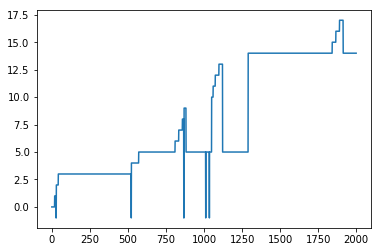

In [333]:
# не шум, но кластер со смыслом
ind_c= np.where(X_scale_clast !=-1)[0]
print('первый элемент кластера',X_scale_clast[ind_c[0]],' : ',clast.components_[0])
print('Число кластеров с масштабированием: ',len(np.unique(X_scale_clast)-1))

n_noise = list(clast.labels_).count(-1)

print('Число не кластеров: ',n_noise)

plt.plot(X_scale_clast)
plt.show()

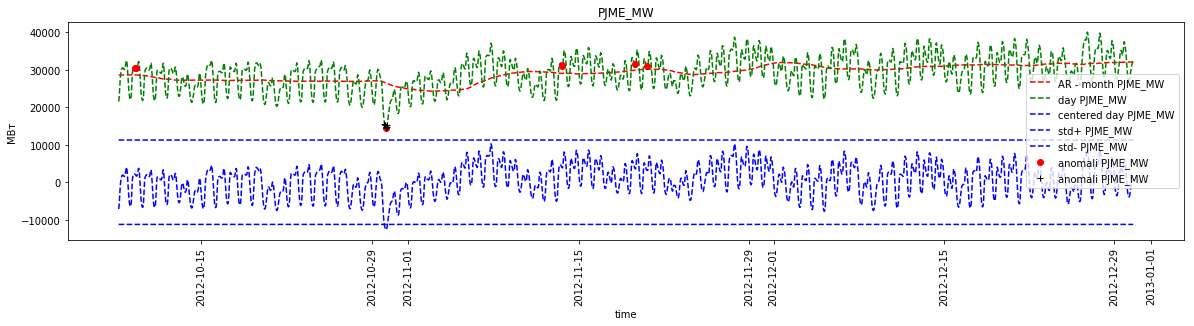

In [93]:
ind_anomal_c= np.where(X_scale_clast ==-1)[0]  # индексы аномалий (наверное аномалий - будем смотреть)

ind_anomal_c = np.array(ind_anomal_c)+p+2  


plt.figure(figsize =(20,4))
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.plot(data['data_time'].iloc[-51000:-49000],data_d[-51000:-49000],'--r',label='AR - month PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day[-51000:-49000],'--g',label='day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day_month[-51000:-49000],'--b',label='centered day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],[-sigma3_diff_day_month]*2000 ,'--b',label='std+ PJME_MW')

plt.plot(data['data_time'].iloc[-51000:-49000],[sigma3_diff_day_month]*2000 ,'--b',label='std- PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000].values[ind_anomal_c],diff_day[-51000:-49000].values[ind_anomal_c],'or',label='anomali PJME_MW') 
plt.plot(data['data_time'].iloc[-51000:-49000].values[ind_],diff_day[-51000:-49000].values[ind_],'+k',label='anomali PJME_MW') 

plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()


Добавили анализ по кластерам к анализу по статистике скользящих окон и видим совпадение точки для 30.10.2012. Можно расчитывать на то, что это аномалия. Однако проверим еще раз используя модель ряда.

In [116]:


data_month=data['PJME_MW'].resample("W").apply('mean')

np.where(data_month.index.weekofyear == pd.to_datetime('2012-10-30').weekofyear)[0]

array([ 43,  95, 147, 200, 252, 304, 356, 408, 461, 513, 565, 617, 669,
       721, 774, 826], dtype=int64)

Сделаем ресемплинг, для ускорения работы модели на недельные отсчеты. Построим модель ряда по ARIMA (опираясь на результаты урока 2)

In [126]:


mod = sm.tsa.statespace.SARIMAX(data_month.values[200:560],order=[2,1,2],
                                seasonal_order=[1,2,2,26] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)



AIC:{} 4811.202741814382


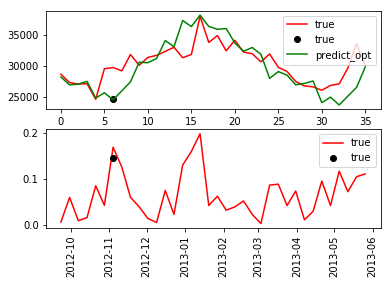

In [146]:
  
pred_dynamic_opt = results_opt.forecast(12*3)
plt.subplot(2,1,1)
plt.plot( data_month.values[561:561+12*3], 'r',label='true' )
plt.plot( 6,data_month.values[565], 'ok',label='true' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
plt.legend()
plt.subplot(2,1,2)

plt.plot( data_month.index[560-1:560+12*3-1],np.abs(data_month.values[560:560+12*3]-pred_dynamic_opt)/data_month.values[560:560+12*3], 'r',label='true' )
plt.plot( data_month.index[565],np.abs(data_month.values[565]-pred_dynamic_opt[0])/data_month.values[565], 'ok',label='true' )
plt.xticks(rotation='90')
plt.legend()
plt.show()

Видно, что аномалия 2012.10.30 лежит на уровне больших ошибок. Это позволяет ее с хорошей вероятностью считать аномалией поведения ряда (на других участках ряда эта модель дает примерно одинаковые ошибки, а тут видим значительное возрастание ошибки на отрезке до 1 месяца). Таким образом подтверждена проблема ряда 30.10.2012.


Замечание:
Визуальный анализ и анализ уровней выявляет аномалию амплитуды, однако не выявит аномалии частотного типа. Для этого следует перейти не к статистикам ряда, а к методам частотного анализа (спектральным моделям анализа ряда, например).

**КАК ИСПОЛЬЗОВАТЬ АНОМАЛИИ:**
 - Построить набор примеров для классификации следующих аномалий.
 - Проверить модель на следующих интервалах, вдруг это не аномалия.

## Brent 2010-2019
Перейдем ко второму примеру. Цена нефти марки Brent. Данные по дням от 2010 до 2019 . Данные были обработаны, но не меняли основное содержание ключевого признака. Отличие от исходного описания - дополнение признаками по календарю, как и в первом примере.

In [334]:

path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


Общий вид изменения цены по ряду приведен на рис.2.

Text(0.5, 0, 't')

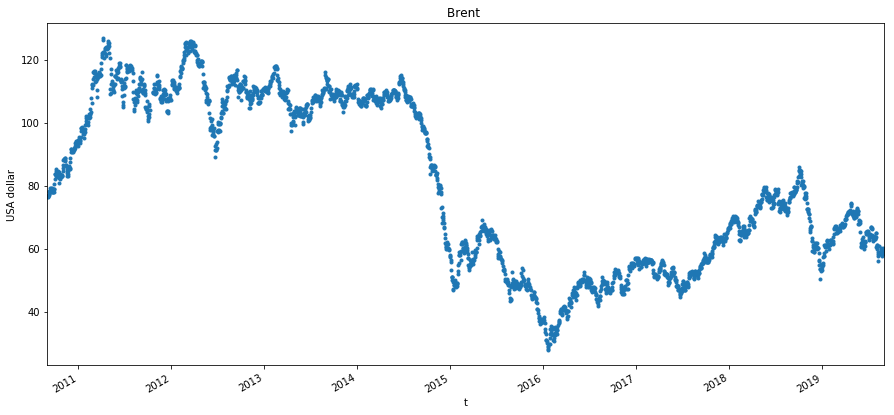

In [335]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

Рис.3 Цена нефти с 2010 по 2019

Помним, что наиболее интересным для и интерпретируемым у этого ряда является поведение его первых разностей
Построим их и посмотрим на аномалии этой части нашей модели.

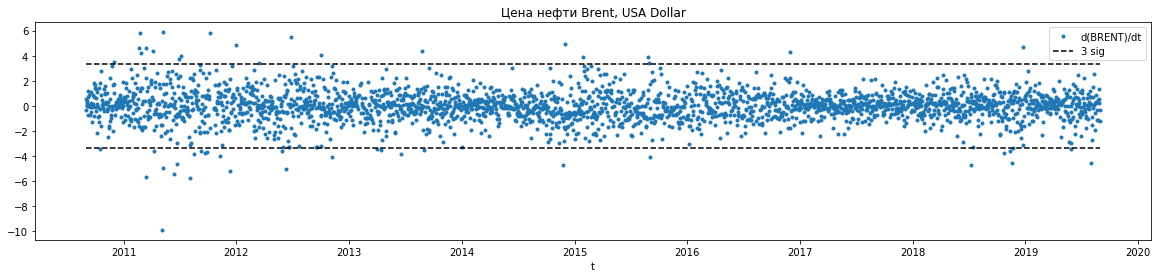

In [336]:
d_brent_data = brent_data['Значение'].values[1:]- brent_data['Значение'].values[:-1]
s_brent = np.std(d_brent_data)**0.5 *3
plt.figure(figsize=(20,4))
plt.plot(brent_data.iloc[:-1].index,d_brent_data,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_brent = np.where( abs(d_brent_data)>s_brent)[0]



Рис.4 BRENT первые разности

Text(0.5, 0, 't')

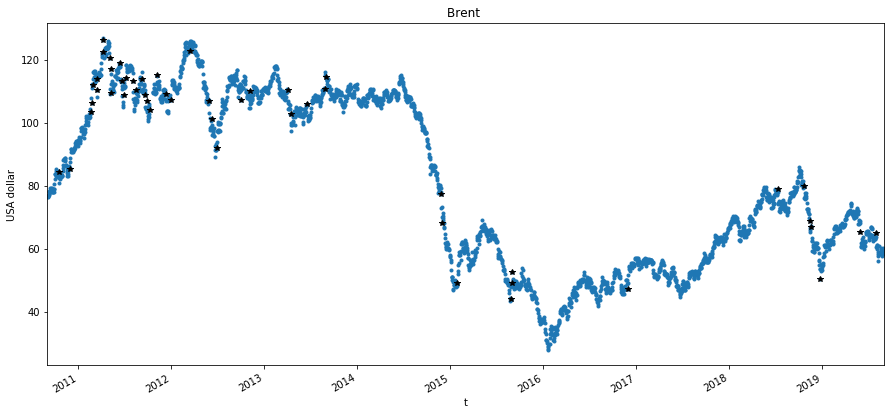

In [337]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(brent_data.iloc[ind_anomal_brent].index,brent_data['Значение'].values[ind_anomal_brent],'*k', label='BRENT anomaly')
plt.ylabel('USA dollar')
plt.xlabel('t')

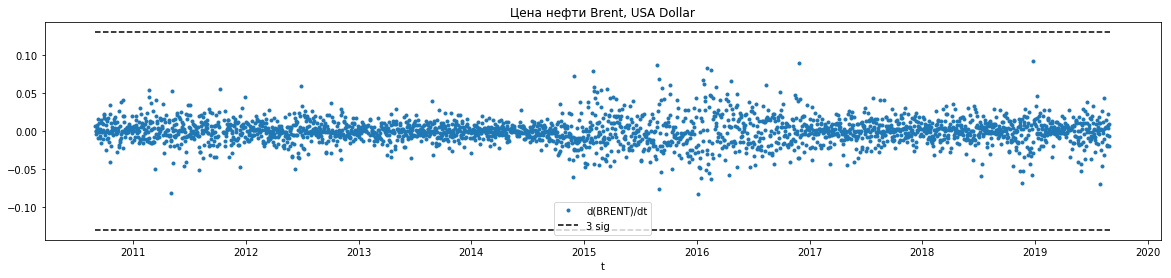

In [154]:
d_brent_data1 = (brent_data['Значение'].values[1:]- brent_data['Значение'].values[:-1])/brent_data['Значение'].values[:-1]

s_brent1 = np.std(d_brent_data1)**0.5 
plt.figure(figsize=(20,4))
plt.plot(brent_data.iloc[:-1].index,d_brent_data1,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent1, s_brent1],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent1, -s_brent1],'--k')
plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_brent1 = np.where( abs(d_brent_data1)>s_brent1)[0]

In [155]:
brent_data.index[[0,-1]]

DatetimeIndex(['2010-09-01', '2019-09-01'], dtype='datetime64[ns]', name='Дата', freq=None)

In [338]:
p =3

#добавляем историю длиной р
for i in range(p):
    brent_data['t'+str(p-i+1)]=0
    brent_data['t'+str(p-i+1)].values[p+2:] = brent_data['Значение'].values[i+1:-(p-i+1)]
for i in range(p):
    brent_data['d'+str(p-i+1)]=0    
    brent_data['d'+str(p-i+1)].values[i+1:] =( (brent_data['Значение'].values[i+1:]- brent_data['Значение'].values[i:-1]))


In [339]:

X = brent_data.iloc[p+2:,:].values

Xscale = scl.fit_transform(X)

clast = DBSCAN(eps=2.9, leaf_size=1, min_samples = 3)
X_scale_clast =clast.fit_predict(Xscale)


первый элемент кластера 0  :  [-0.17721153 -1.75698575  0.72500659 -1.11065221  0.44539858  0.63193593
  0.63776124 -1.33798808  5.91379514 -0.16553715 -0.17488451 -0.19246036
 -0.19219421 -0.19194461  0.00947192  0.00947192  0.00947192]
Число кластеров с масштабированием:  8
Число не кластеров:  20


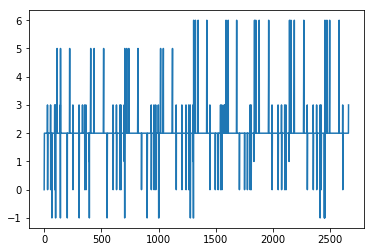

In [340]:
# не шум, но кластер со смыслом
ind_= np.where(X_scale_clast !=-1)[0]
print('первый элемент кластера',X_scale_clast[ind_[0]],' : ',clast.components_[0])
print('Число кластеров с масштабированием: ',len(np.unique(X_scale_clast)-1))

n_noise = list(clast.labels_).count(-1)

print('Число не кластеров: ',n_noise)

plt.plot(X_scale_clast)
plt.show()

Text(0.5, 0, 't')

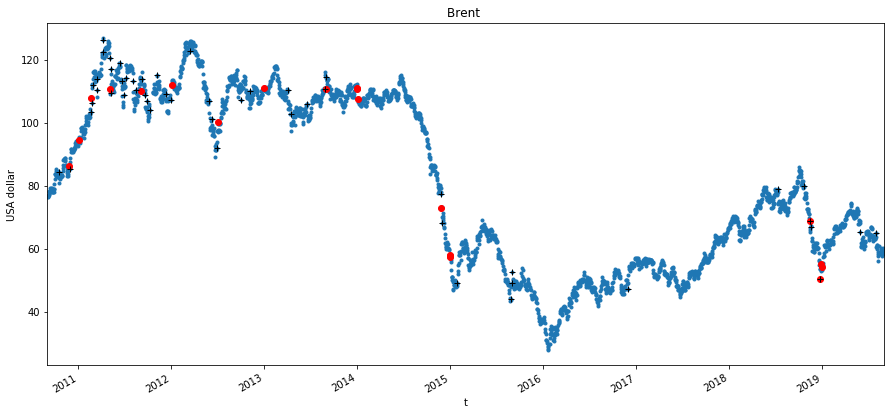

In [341]:
ind_anomal_brent_c= np.where(X_scale_clast ==-1)[0]  # индексы аномалий (наверное аномалий - будем смотреть)

ind_anomal_brent_c = np.array(ind_anomal_brent_c)+p+2  

_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(brent_data.iloc[ind_anomal_brent_c].index,brent_data['Значение'].values[ind_anomal_brent_c],'or', label='BRENT anomaly claster')
plt.plot(brent_data.iloc[ind_anomal_brent].index,brent_data['Значение'].values[ind_anomal_brent],'+k', label='BRENT anomaly stat')

plt.ylabel('USA dollar')
plt.xlabel('t')


Построили несколько кандидатов на аномальное поведение. Попробуем определить какой-нибудь дополнительный способ анализа.

## Генерация признаков  из внешних источников

Естественным попутчиком любого финансово -ориентированного ряда является кросс-курс валют. В случае BRENT патриотично рассматриваем кросс-курс доллар-рубль (стоимость доллара в рублях) и евро-рубль (стоимость евро в рублях). Интервал измерения стоимости доллара и евро соответствует частоте и периоду нашего ряда "стоимость нефти", а источник данных https://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01235&UniDbQuery.FromDate=01.09.2010&UniDbQuery.ToDate=01.09.2019, который позволяет сохранить результаты в нескольких различных вариантах. Прочитаем, сохраненные данные.

In [342]:
rub_doll=pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx')
rub_doll.index = pd.to_datetime(rub_doll['data'].values).date
rub_doll.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_doll.head()



,curs
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [343]:
rub_e=pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx')
rub_e.index = pd.to_datetime(rub_e['data'].values).date
rub_e.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_e.head()

,curs
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


И сделаем их визуализацию.

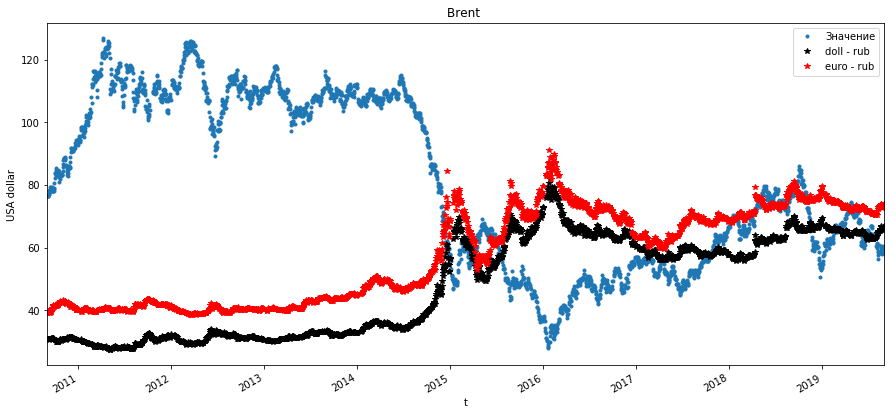

In [344]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(rub_doll.index,rub_doll['curs'].values,'*k', label='doll - rub')
plt.plot(rub_e.index,rub_e['curs'].values,'*r', label='euro - rub')
plt.ylabel('USA dollar')
plt.xlabel('t')
plt.legend()
plt.show()

Посмотрим на первые разности. Помним, что для BRENT первые разности стационарны. Проверим как выглядят они для кросс-курсов.

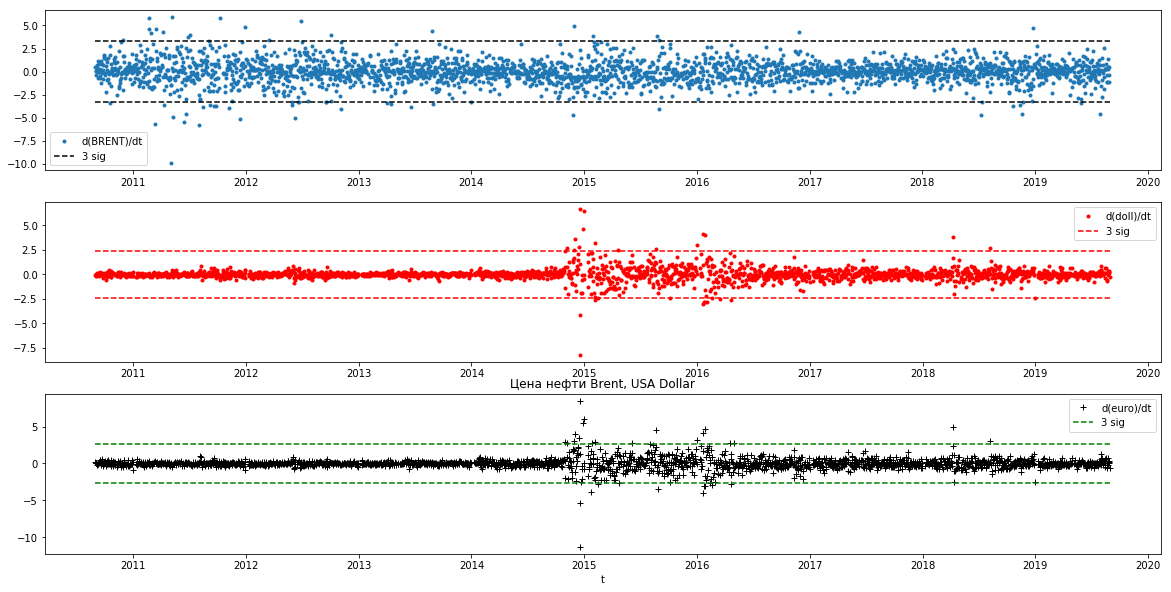

In [345]:
d_rub_doll = rub_doll['curs'].values[1:]- rub_doll['curs'].values[:-1]
s_rub = np.std(d_rub_doll)**0.5 *3

d_rub_e = rub_e['curs'].values[1:]- rub_e['curs'].values[:-1]
s_rube = np.std(d_rub_e)**0.5 *3

plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(brent_data.iloc[:-1].index,d_brent_data,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.legend()

plt.subplot(3,1,2)
plt.plot(rub_doll.iloc[:-1].index,d_rub_doll,'.r', label='d(doll)/dt')
plt.plot(rub_doll.iloc[[0,-1]].index,[s_rub, s_rub],'--r',label ='3 sig')
plt.plot(rub_doll.iloc[[0,-1]].index,[-s_rub, -s_rub],'--r')
plt.legend()

plt.subplot(3,1,3)
plt.plot(rub_e.iloc[:-1].index,d_rub_e,'+k', label='d(euro)/dt')
plt.plot(rub_e.iloc[[0,-1]].index,[s_rube, s_rube],'--g',label ='3 sig')
plt.plot(rub_e.iloc[[0,-1]].index,[-s_rube, -s_rube],'--g')

plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_brent = np.where( abs(d_brent_data)>s_brent)[0]
ind_anomal_rubl_d = np.where( abs(d_rub_doll)>s_rub)[0]
ind_anomal_rubl_e = np.where( abs(d_rub_e)>s_rube)[0]

   


Сопоставим списки результатов, которые вышли за границы 3 сигма.

In [346]:
ind_anomal_brent

array([  41,   78,  146,  148,  153,  164,  166,  184,  186,  206,  209,
        211,  240,  247,  252,  259,  283,  295,  314,  325,  330,  340,
        357,  386,  399,  462,  525,  535,  551,  634,  663,  777,  787,
        844,  900,  904, 1282, 1285, 1335, 1494, 1496, 1497, 1818, 2311,
       2400, 2418, 2424, 2454, 2586, 2639], dtype=int64)

In [347]:
ind_anomal_rubl_d

array([1037, 1039, 1055, 1057, 1066, 1067, 1068, 1070, 1075, 1078, 1096,
       1097, 1103, 1147, 1232, 1264, 1325, 1333, 1334, 1335, 1336, 1337,
       1343, 1353, 1370, 1393, 1881, 1964, 2066], dtype=int64)

In [348]:
ind_anomal_rubl_e

array([1037, 1039, 1055, 1057, 1066, 1067, 1068, 1070, 1075, 1078, 1087,
       1089, 1096, 1103, 1149, 1176, 1232, 1235, 1325, 1333, 1334, 1335,
       1336, 1337, 1350, 1353, 1392, 1393, 1402, 1881, 1964], dtype=int64)

Есть пересечение всех трех множеств объект с номером 1335. Покажем этот и несколько соседних объектов (они сильно выпадают из ряда у кросс-курсов): 

In [349]:
rub_doll.index[[1333, 1334, 1335, 1336, 1337]]

Index([2016-01-21, 2016-01-22, 2016-01-23, 2016-01-26, 2016-01-27], dtype='object')

Проблема кросс-курса с рублем в том, что трудно сказать курс зависит от цены  нефти или цена от курса (но по логике экономики должен курс рубля зависеть от цены нефти). 2016 в январе курс к доллару составил 82 р (https://www.gazeta.ru/business/2016/01/20/8031815.shtml) на фоне резкого падения цены нефти (иранский фактор - сняли эмбарго на экспорт в начале января). Однако, если в некоторый день цена нефти и кросс-курс ведут себя разнонаправленно, то можно предположить. что это не глобальное явление, а некоторый случайный выброс. Декабрь 2015-январь 2016 - смена уровня , т.е. глобальное изменение ряда по типу аномалии "изменение характера (распределения) значений". В данном случае сильно изменяется средняя ряда.

Добавим стоимость валюты в рублях

In [350]:
brent_data['doll']=0
brent_data['doll'].values[1:2229]=rub_doll['curs'].values[:]
brent_data=brent_data.iloc[:2229,:]

В итоге данные примут вид 

In [351]:
brent_data.iloc[100:115,:]


,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,t4,t3,t2,d4,d3,d2,doll
Дата,,,,,,,,,,,,,,,,,,
2010-12-27,93.71,2010,12,27,4,361,52,0,0,0,0,93,94,93,0,0,0,29
2010-12-28,94.21,2010,12,28,4,362,52,1,0,0,0,94,93,93,0,0,0,29
2010-12-29,94.03,2010,12,29,4,363,52,2,0,0,0,93,93,93,0,0,0,29
2010-12-30,92.71,2010,12,30,4,364,52,3,0,1,0,93,93,94,-1,-1,-1,29
2010-12-31,94.59,2010,12,31,4,365,52,4,1,0,0,93,94,94,1,1,1,29
2011-01-02,94.56,2011,1,2,1,2,52,6,0,0,0,94,94,92,0,0,0,29
2011-01-03,94.85,2011,1,3,1,3,1,0,0,0,0,94,92,94,0,0,0,29
2011-01-05,95.54,2011,1,5,1,5,1,2,0,0,0,92,94,94,0,0,0,29
2011-01-06,94.43,2011,1,6,1,6,1,3,0,0,0,94,94,94,-1,-1,-1,29


## Выделение существенных признаков

Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1) 

In [405]:
scl_target=StandardScaler() 

h=14
target = brent_data["Значение"].values[h:].reshape((brent_data.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

(2215, 1)

In [406]:
scl_x=StandardScaler() 

X = brent_data.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(2215, 18)

Размеры выборок по строкам совпали. Мы взяли на h строк меньше для Х и на h значений позднее по target. Таким образом, входной набор данных сформирован.

In [407]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())

for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))


F-test=82279.92,  I=0
F-test=3535.23,  I=1
F-test=3.32,  I=2
F-test=0.14,  I=3
F-test=3.09,  I=4
F-test=3.25,  I=5
F-test=3.03,  I=6
F-test=14.55,  I=7
F-test=0.42,  I=8
F-test=0.27,  I=9
F-test=0.36,  I=10
F-test=41409.57,  I=11
F-test=43170.35,  I=12
F-test=45026.88,  I=13
F-test=1.03,  I=14
F-test=1.03,  I=15
F-test=1.03,  I=16
F-test=4036.14,  I=17


Проверка через F-test показывает, что есть корреляционная связь с предшествующим значением ряда (признак X[:,0]), а кроме этого интересные признаки 1 , 7, 11, 12, 13 и 17. Применим автоматизацию выбора через SelectKBest c выделением 5 лучших признаков.

In [408]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(2215, 5)

Лучшее множество признаков отделенов X_new1. Проверим результат оценки признаков по процентному отбору и сохраним его в X_new2.

In [409]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(2215, 2)

Наконец, третий вариант - применим выделение признаков через построение модели . Помним , что модель должна уметь выбрать подмножество признаков или вернуть коэффициент их влиятельности. Это ограничивает выбор моделей. Возьмем как оценшик GradientBoostingRegressor и построим новое пространство в X_new3

In [410]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(2215, 1)

Сравним результаты:


In [411]:
[X_new1[:5,:], X_new2[:5,:],X_new3[:5,:]]

[array([[-0.27318418, -2.94151482, -2.94105826, -2.94064901, -2.99391049],
        [-0.25465991, -2.94151482, -2.94105826, -2.94064901, -1.10238143],
        [-0.26605946, -2.94151482, -2.94105826, -2.94064901, -1.10238143],
        [-0.26427828, -2.94151482, -2.94105826, -2.94064901, -1.10238143],
        [-0.26392204, -2.94151482, -2.94105826, -2.94064901, -1.10238143]]),
 array([[-0.27318418, -2.94064901],
        [-0.25465991, -2.94064901],
        [-0.26605946, -2.94064901],
        [-0.26427828, -2.94064901],
        [-0.26392204, -2.94064901]]),
 array([[-0.27318418],
        [-0.25465991],
        [-0.26605946],
        [-0.26427828],
        [-0.26392204]])]

In [412]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 11 12 13 17]
Номера признаков лучших признаков по процентной форме:  [ 0 13]
Номера признаков для выбора по модели :  [0]


Пересечение выбора по отбору для модели и по количественным оценкам связи в признаке 0. Имеет смысл брать объединение выборов. Возьмем [0,6,14,21] признаки и перейдем к построению модели.

In [413]:
X_new = X[:,[0,1,11,12,13,17]]


## Разделение данных на тестовые и тренировочные 

Построение модели начинаем с выделения тестовой части нашего ряда. Напомним, что для временных рядов тест - непрерывная часть ряда не входившая в обучение (временные ряды 1). Будем отделять по индексу, который задаст дату разделения модели на тест и обучение.

In [414]:
# сделаем функцию
def split_data( data, split_date ):
    return data.iloc[:split_date,:].copy(), \
           data.iloc[split_date:,:].copy()

Для временного ряда "Потребление энергии" назначим датой разделения 1/06/2016

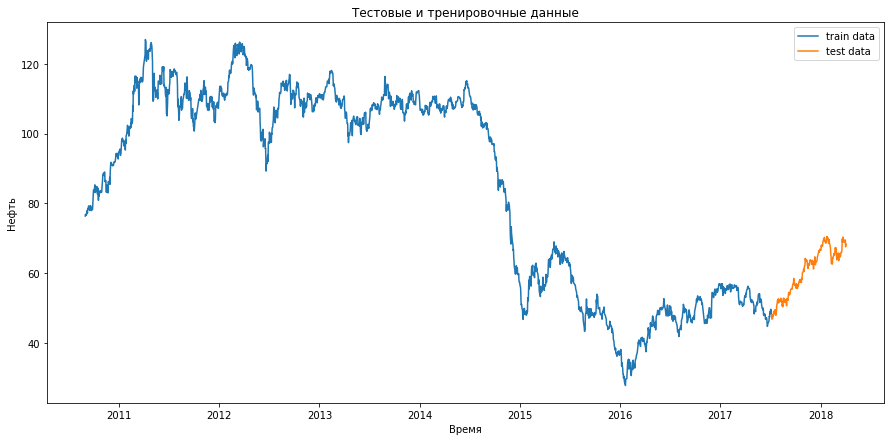

In [415]:
train, test = split_data( brent_data, 2000)

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(train.index,train.iloc[:,0], label='train data' )
plt.plot(test.index,test.iloc[:,0], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [416]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [417]:
train.shape

(2000, 18)

Выделим описание объекта и целевое свойство для тестовой и тренировочной частей ряда. Перейдем к построению моделей.  

# Строим Модель

При решении задачи на начальном этапе, самый интересный результат был получен на модели GradientBoostingRegressor. Остановимся на построении иенно такой формы предсказания. Импортируем необходимые модели.

In [418]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

Все модели возьмем в варианте параметров по умолчанию.

In [419]:
model_g = GradientBoostingRegressor(max_depth=4, random_state=0, n_estimators=1500)
model_l = LinearRegression()

Запускаем модели и смотрим , что они построят на наших примерах.

In [420]:
model_l.fit( X_train, y_train ) # 
model_g.fit( X_train, y_train ) 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1500, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

**Посмотрим тесты**

In [421]:
X_test.shape

(215, 6)

In [422]:
y_test_pred_g = model_g.predict(X_test)
y_test_pred_l= model_l.predict(X_test)

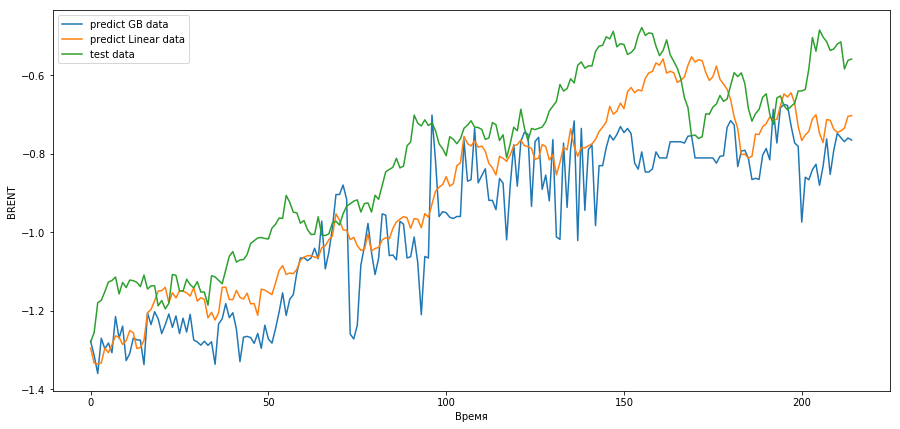

In [423]:

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g, label='predict GB data' )
plt.plot(y_test_pred_l, label='predict Linear data' )
plt.plot(y_test, label='test data')

plt.legend()
plt.show()

In [424]:
y_pred_g = model_g.predict(X_train)
y_pred_l= model_l.predict(X_train)

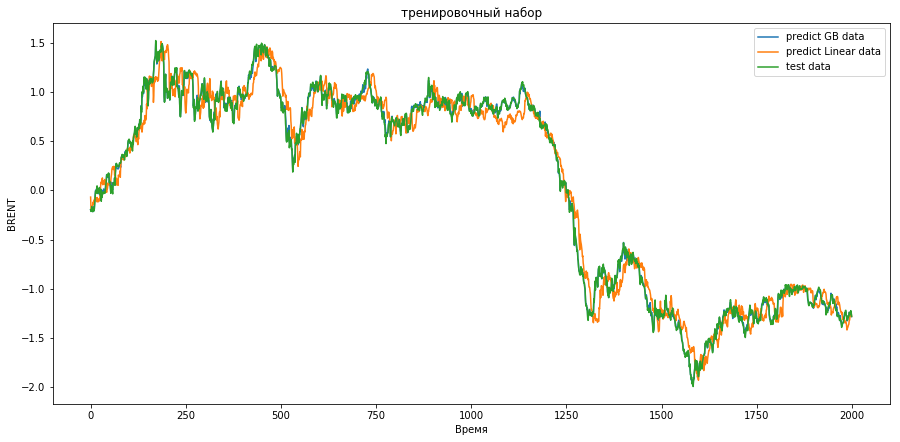

In [426]:
plt.figure( figsize=( 15, 7 ))

plt.title('тренировочный набор')
plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_pred_g, label='predict GB data' )
plt.plot(y_pred_l, label='predict Linear data' )
plt.plot(y_train, label='test data')

plt.legend()
plt.show()

Линейная модель практически не работает, т.к. видно запаздывание в размере h.Градиентный бустинг практически не отличается от нее на интервале обучения. Посмотрим на оценки.

**Оценки для сравнения моделей**

In [428]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [429]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.0393032811722932 
ошибка mae  :   0.1714642649876656 
оценка R2 :   0.17762460083409792


Абсолютная процентная ошибка (MAPE).Обратите внимание, что определять ее для масштабированной переменной не верно. Поэтому переведем ответ решателя обратно в состояние без масштаба.

In [430]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [431]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   7.7681351354690955 %


In [432]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: -0.044 (std: 1.106)
Parameters: {'n_estimators': 100, 'max_depth': 1}

Model with rank: 2
Mean validation score: -0.084 (std: 1.136)
Parameters: {'n_estimators': 300, 'max_depth': 1}

Model with rank: 3
Mean validation score: -0.269 (std: 0.862)
Parameters: {'n_estimators': 100, 'max_depth': 5}



In [433]:
model_g_best = GradientBoostingRegressor(max_depth=4,  n_estimators=100)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   5.553036385940663 %


Качество решения задачи по MAPE повысилось почти на 2%. 


## Сохраниение модели

In [434]:
import pickle
# save the model to disk
filename = 'final_model_brent.sav'
pickle.dump(model_g_best, open(filename, 'wb'))

filename = 'final_scaler_brent_y.sav'
pickle.dump(scl_target, open(filename, 'wb'))

filename = 'final_scaler_brent_x.sav'
pickle.dump(scl_x, open(filename, 'wb'))


## Заключение

Прогнозирование на основе обучения позволяет эффективно описывать достаточно сложные данные. Построение прогноза на основе генерации регрессионных моделей позволит построить хороший ответ даже не зная как устроен ряд и каковы его статистические свойства. При решении задачи прогнозирования следует учитывать следующие особенности этого подхода:
- Строим много признаков.
- Обрабатываем признаки и используем результаты статистического анализа ряда для придумывания новых признаков.
- Строим много моделей и не забываем, что тестирование моделей идет только на последних точках ряда.
- Используем правильные метрики.
- Следим за аномалиями



## Задание

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю
3. сделайте ее перрасчет (ресемплинг) в представление по неделям. 
4. Постройте модель предсказания 1-й точки от текущей (h=1).

5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.